#### Imports

In [1847]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns


from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error, r2_score

#### Read tsv file as csv

In [3]:
data = pd.read_csv('C:\\Users\\or.hirshman\\Documents\\\learning\\DS_Projects\\similarweb\\DQ_Data_b.tsv', sep='\t')

### Analysis:

#### See how some observations in the data look

In [4]:
data.head()

,source,site,% U,V
0,0,06880danwoog.com*,3.343111e-06,36280.0
1,0,0800-horoscope.com*,1.075026e-05,120690.0
2,0,10000boatnames.com*,5.871362e-07,6858.0
3,0,100bestvacations.com*,1.516845e-06,12891.0
4,0,100stuartstreet.com*,1.128228e-06,9758.0


#### We have 28364 entries, and 4 columns

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28364 entries, 0 to 28363
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28364 non-null  int64  
 1   site    28364 non-null  object 
 2   % U     28364 non-null  float64
 3   V       28364 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 886.5+ KB


#### We can see that for both V and %U:
#### The Std is high, the difference between the min and max values is high (~1,000,000 diff), 75% of the data does not have huge values

In [6]:
data.describe()

,source,% U,V
count,28364.000000,2.836400e+04,2.836400e+04
mean,1.136723,1.278015e-04,1.337023e+06
std,1.021121,3.093624e-03,3.460400e+07
min,0.000000,1.045405e-07,1.020107e+03
25%,0.000000,2.165681e-06,2.085839e+04
50%,1.000000,7.001150e-06,6.868358e+04
75%,2.000000,3.019798e-05,3.009082e+05
max,3.000000,4.345977e-01,4.872713e+09


#### Check for Nulls - There ane no Nulls for all entries

In [7]:
data.isnull().sum()

source    0
site      0
% U       0
V         0
dtype: int64

#### How many unique sites are in the dataset?

In [8]:
len(data.site.unique())

9699

#### Pie chart for all source types - More than 1\3 of the data is in the learning set, 30% are in source 1, 24% in source 2, 12% in source 3

Text(0.5, 1.0, 'All sources pie chart')

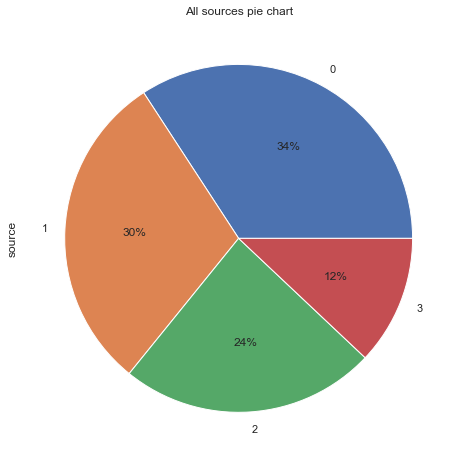

In [389]:
data['source'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('All sources pie chart')

#### Create a separate dataframe for each data source

In [10]:
data0 = data[data['source'] == 0]
data1 = data[data['source'] == 1]
data2 = data[data['source'] == 2]
data3 = data[data['source'] == 3]

#### We can see that each dataset does not contain the same sites as the learning set

In [1095]:
display(data0)
display(data1)
display(data2)
display(data3)

,source,site,% U,V
0,0,06880danwoog.com*,0.0000033431,36280.0000000000
1,0,0800-horoscope.com*,0.0000107503,120690.0000000000
2,0,10000boatnames.com*,0.0000005871,6858.0000000000
3,0,100bestvacations.com*,0.0000015168,12891.0000000000
4,0,100stuartstreet.com*,0.0000011282,9758.0000000000
...,...,...,...,...
9694,0,zurinstitute.com*,0.0000032164,28788.0000000000
9695,0,zvents.com*,0.0000938797,740008.0000000000
9696,0,zx6r.com*,0.0000040948,57444.0000000000
9697,0,zybez.net*,0.0000762851,1237033.0000000000


,source,site,% U,V
9699,1,06880danwoog.com*,0.0000050648,74508.9416692836
9700,1,0800-horoscope.com*,0.0000079767,88514.4705800152
9701,1,10000boatnames.com*,0.0000007662,7476.7074182638
9702,1,100bestvacations.com*,0.0000010830,10568.1874182638
9703,1,100stuartstreet.com*,0.0000019191,18726.7353686582
...,...,...,...,...
18196,1,zurinstitute.com*,0.0000047378,48461.9202493382
18197,1,zvents.com*,0.0001431665,1444088.1939295200
18198,1,zx6r.com*,0.0000047909,46750.0588951523
18199,1,zybez.net*,0.0001081722,1473999.8323633601


,source,site,% U,V
18201,2,06880danwoog.com*,0.0000086720,77524.4506031888
18202,2,0800-horoscope.com*,0.0000192860,172408.7952948560
18203,2,1015store.com*,0.0000403516,360727.3543211320
18204,2,101kgb.com*,0.0000144064,128787.7959416120
18205,2,101science.com*,0.0000006500,5810.5367644285
...,...,...,...,...
24945,2,ztgd.com*,0.0000020394,18231.6258445991
24946,2,zvents.com*,0.0000848672,797346.2416047510
24947,2,zx6r.com*,0.0000082306,73578.2152750954
24948,2,zybez.net*,0.0001244973,1326869.1707306199


,source,site,% U,V
24950,3,0800-horoscope.com*,0.0000087937,74442.3414620303
24951,3,1015store.com*,0.0000134886,129225.5427621610
24952,3,101kgb.com*,0.0000129910,109974.4146642270
24953,3,101science.com*,0.0000008284,7012.7632342178
24954,3,1035kissfm.com*,0.0000137343,116266.2841379230
...,...,...,...,...
28359,3,zonebourse.com*,0.0000011568,11197.6040235910
28360,3,zoochat.com*,0.0000033723,28548.0562232387
28361,3,zvents.com*,0.0000808304,684262.0951674310
28362,3,zybez.net*,0.0000980263,923140.2023787440


#### Describe for each dataframe

In [12]:
display(data0.describe())
display(data1.describe())
display(data2.describe())
display(data3.describe())

,source,% U,V
count,9699.0,9.699000e+03,9.699000e+03
mean,0.0,6.249331e-05,6.493156e+05
std,0.0,4.802266e-04,5.558451e+06
min,0.0,2.790000e-07,5.001000e+03
25%,0.0,1.486785e-06,1.424450e+04
50%,0.0,4.236642e-06,4.119500e+04
75%,0.0,1.697491e-05,1.731955e+05
max,0.0,2.085859e-02,2.619745e+08


,source,% U,V
count,8502.0,8.502000e+03,8.502000e+03
mean,1.0,7.291470e-05,8.054732e+05
std,0.0,6.688866e-04,7.577127e+06
min,1.0,1.045405e-07,1.020107e+03
25%,1.0,1.660861e-06,1.715018e+04
50%,1.0,4.944889e-06,5.204454e+04
75%,1.0,1.875423e-05,2.008795e+05
max,1.0,3.308058e-02,3.713884e+08


,source,% U,V
count,6749.0,6.749000e+03,6.749000e+03
mean,2.0,1.779296e-04,1.831009e+06
std,0.0,1.476425e-03,1.643595e+07
min,2.0,3.550000e-07,3.173740e+03
25%,2.0,4.893127e-06,4.531102e+04
50%,2.0,1.532759e-05,1.429922e+05
75%,2.0,5.589029e-05,5.349521e+05
max,2.0,6.195002e-02,6.937006e+08


,source,% U,V
count,3414.0,3.414000e+03,3.414000e+03
mean,3.0,3.509293e-04,3.637961e+06
std,0.0,8.566195e-03,9.580350e+07
min,3.0,2.190000e-07,1.854112e+03
25%,3.0,4.115380e-06,3.595316e+04
50%,3.0,1.758527e-05,1.556398e+05
75%,3.0,7.005734e-05,6.235831e+05
max,3.0,4.345977e-01,4.872713e+09


### Comparison between learning set and source1:
#### It seems that by all paramters (mean, std, min, 25%, 50%, 75%, max) the values of both V and %U in the learning set and source1 are in the same scale
### Comparison between learning set and source2:
#### It seems that for most of the paramters (min, 25%, 75%, max) the values of both V and %U in the learning set and source2 are  in the same scale, for the other parameters (mean, std, 50%) there is a difference of *10 or /10 for both V and %U 
### Comparison between learning set and source3:
#### It seems that for some of the paramters (min, 25%, 75%) the values of both V and %U in the learning set and source2 are in the same scale, for most of the parameters (mean, std, 50%, max) there isa difference of *10  or 1/10 for both V and %U 
### At this point our hypothesis is that source1 is the closest source to the learning source, then source2, then source3
###   

#### Check if each of the sources (1-3) contains sites which are not in the learning set by using setdiff1d - returns the unique values in arr1 that are not in arr2.
#### The learning set contains all the sites which are in each source (1-3)

In [14]:
arr_data0 = data0['site'].to_numpy()
arr_data1 = data1['site'].to_numpy()
arr_data2 = data2['site'].to_numpy()
arr_data3 = data3['site'].to_numpy()

display(np.setdiff1d(arr_data1, arr_data0))
display(np.setdiff1d(arr_data2, arr_data0))
display(np.setdiff1d(arr_data3, arr_data0))

array([], dtype=object)

array([], dtype=object)

array([], dtype=object)

#### Check if the learning set contains sites which are not in the sources (1-3), and check if those items are the same for each source
#### The learning set contains different sites which are not included in the sources (1-3). Each source (1-3) contains different sites. For example '10000boatnames.com*' appears at the learning set and at source1 but not at source2 and source3

In [1136]:
in_0_not1 = np.setdiff1d(arr_data0, arr_data1)
in_0_not2 =np.setdiff1d(arr_data0, arr_data2)
in_0_not3 =np.setdiff1d(arr_data0, arr_data3)

display(in_0_not1)
display(in_0_not2)
display(in_0_not3)

array(['1073thewave.net*', '108.fm*', '17andbaking.com*', ...,
       'zoecarter.com*', 'zoknowsgaming.com*', 'zonebourse.com*'],
      dtype=object)

array(['10000boatnames.com*', '100bestvacations.com*',
       '100stuartstreet.com*', ..., 'zoochat.com*', 'zoomerradio.ca*',
       'zurinstitute.com*'], dtype=object)

array(['06880danwoog.com*', '10000boatnames.com*',
       '100bestvacations.com*', ..., 'ztgd.com*', 'zurinstitute.com*',
       'zx6r.com*'], dtype=object)

#### Check if there are sites which appear at the learning set but not at any of the external sources

In [1149]:
data0_not_in_external = np.setdiff1d(in_0_not1, in_0_not2)
data0_not_in_external = np.setdiff1d(data0_not_in_external, in_0_not3)
data0_not_in_external

array(['1stoptutorials.com*', 'abcsofattraction.com*',
       'absolutorrent.com*', 'africasacountry.com*',
       'alltheragefaces.com*', 'americanbedu.com*', 'appropedia.org*',
       'arrestedmotion.com*', 'bkconnection.com*',
       'blogdesuperheroes.es*', 'cardiachill.com*', 'cnbluestorm.com*',
       'corporatecomplianceinsights.com*', 'crackingzilla.net*',
       'digimarc.com*', 'dissertationsgratuites.com*', 'dohanews.co*',
       'dotastrategy.com*', 'dreamsescorts.com*', 'e4ebooks.com*',
       'engagebdr.com*', 'english.com.tw*', 'eurolines.com*', 'evolo.us*',
       'exceluser.com*', 'fabcam.net*', 'famereport.com*',
       'foreignpolicyjournal.com*', 'futbolsapiens.com*', 'gearfuse.com*',
       'getgosoft.com*', 'glowtxt.com*', 'hobbyheart.com*',
       'hotbloodedgaming.com*', 'imageamplified.com*', 'indoforum.org*',
       'innovationexcellence.com*', 'japancrush.com*', 'justfreevpn.com*',
       'karlasugar.net*', 'kingeshop.com*', 'koreabridge.net*',
       'linuxb

#### Change floats display format

In [740]:
pd.set_option('display.float_format', lambda x: '%.10f' % x)
data.head()

,source,site,% U,V
0,0,06880danwoog.com*,0.0000033431,36280.0000000000
1,0,0800-horoscope.com*,0.0000107503,120690.0000000000
2,0,10000boatnames.com*,0.0000005871,6858.0000000000
3,0,100bestvacations.com*,0.0000015168,12891.0000000000
4,0,100stuartstreet.com*,0.0000011282,9758.0000000000


### % U histogram in data
#### Most % U values are under 0.001, but we can not see the distribution well

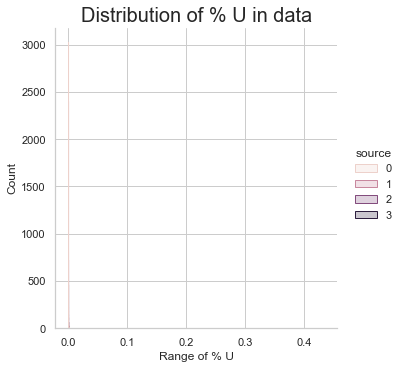

In [410]:
sns.displot(data, x="% U", hue="source", element="step")
plt.title('Distribution of % U in data', fontsize = 20)
plt.xlabel('Range of % U')
plt.ylabel('Count')
plt.show()

### V histogram in data
#### Most V values are under 0.01, but we can not see the distribution well

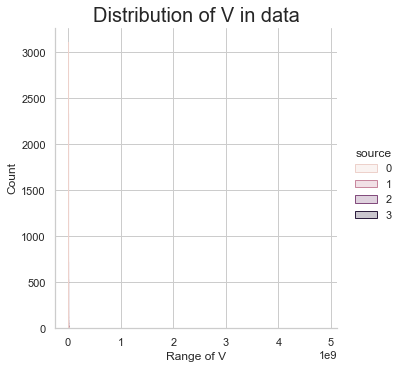

In [46]:
sns.displot(data, x="V", hue="source", element="step")
plt.title('Distribution of V in data', fontsize = 20)
plt.xlabel('Range of V')
plt.ylabel('Count')
plt.show()

### % U histogram with log transformation - 
#### The log transformation can be used to make highly skewed distributions less skewed. This can be valuable for making patterns in the data more interpretable
#### At this point, based on the histogram of log scaled U%, We can see that the learning set %U distribution is the closest to source1, then source2 and then source3.
#### We need to take into consideration the sizes of each external source. We saw at the pie chart that the learning set is the largest, then source1, 2, 3. It means that these histograms are affected by the count of each.

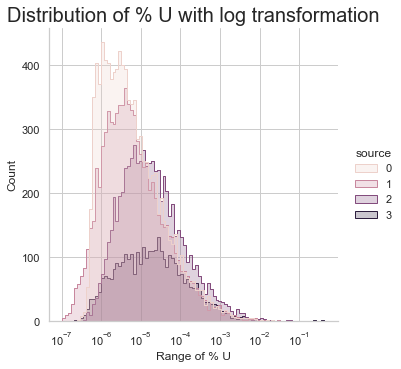

In [318]:
sns.displot(data, x="% U", hue="source", element="step", log_scale=True)
plt.title('Distribution of % U with log transformation', fontsize = 20)
plt.xlabel('Range of % U')
plt.ylabel('Count')
plt.show()

### V histogram with log transformation


#### At this point, based on the log scaled histogram of V, We can see that the learning set V distribution is the closest to source1, then source2 and then source3

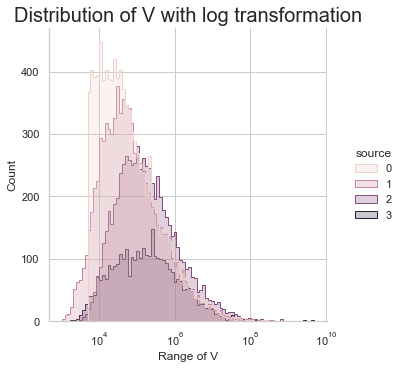

In [48]:
sns.displot(data, x="V", hue="source", element="step", log_scale=True)
plt.title('Distribution of V with log transformation', fontsize = 20)
plt.xlabel('Range of V')
plt.ylabel('Count')
plt.show()

### V * % U histogram with log transformation
#### At this point, based on the log scaled histogram of V * %U, We can see that the learning set V*%U distribution is the closest to source1, then source2 and then source3

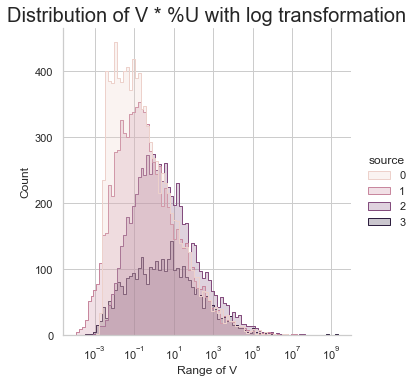

In [411]:
sns.displot(data, x=data["V"]*data["% U"], hue="source", element="step", log_scale=True)
plt.title('Distribution of V * %U with log transformation', fontsize = 20)
plt.xlabel('Range of V')
plt.ylabel('Count')
plt.show()

### Heatmap for learning set, We can see a very high correlation between V and % U in the learning set

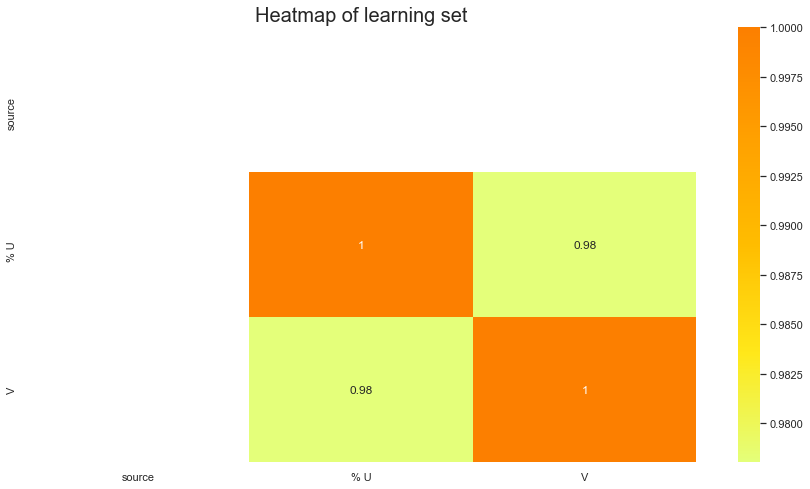

In [388]:
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(data0.corr(), cmap = 'Wistia', annot = True)
plt.title('Heatmap of learning set', fontsize = 20)
plt.show()

### Heatmap for Source 1, We can see a very high correlation between V and % U in Source 1

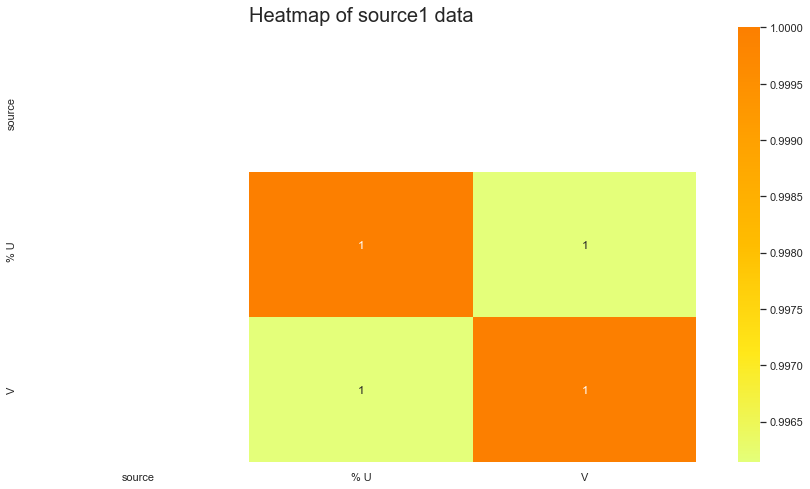

In [384]:
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(data1.corr(), cmap = 'Wistia', annot = True)
plt.title('Heatmap of source1 data', fontsize = 20)
plt.show()

### Heatmap for Source 2, We can see a very high correlation between V and % U in Source 2

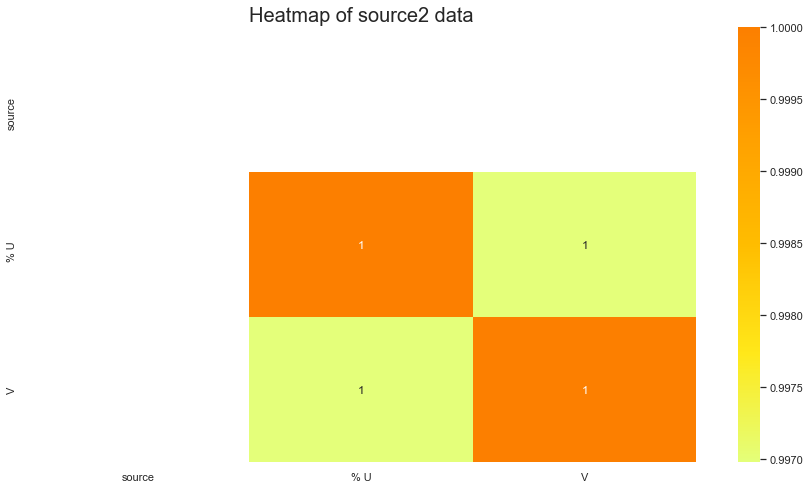

In [387]:
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(data2.corr(), cmap = 'Wistia', annot = True)
plt.title('Heatmap of source2 data', fontsize = 20)
plt.show()

### Heatmap for Source 3, We can see a very high correlation between V and % U in Source 3

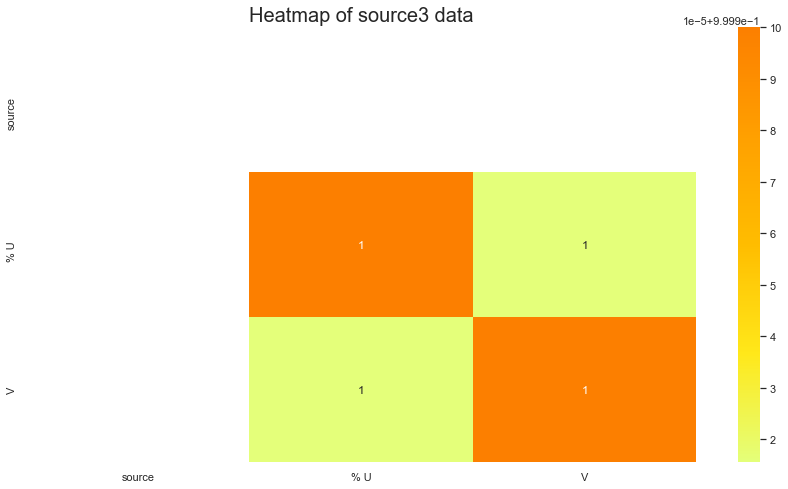

In [386]:
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(data3.corr(), cmap = 'Wistia', annot = True)
plt.title('Heatmap of source3 data', fontsize = 20)
plt.show()

### Scatter plot of % U and V for all data by sources
#### We can see that most of the data is between 0-0.1 %U and 0-1e^9 V, so we will remove the outliers (which are from source3)

Text(0.5, 1.0, ' % U and V by all all sources')

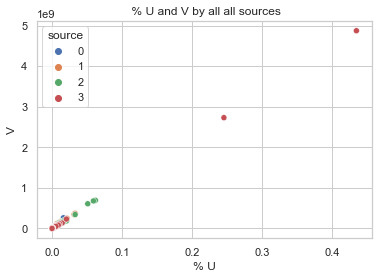

In [381]:
sns.scatterplot(data = data, hue = 'source', x='% U', y='V', palette="deep")
plt.title(' % U and V by all all sources')

#### There are 2 outliers, all from source3, we will remove them

In [59]:
data_without_outliers = data.loc[data['% U'] < 0.1]
len(data_without_outliers)

28362

### Scatter plot of % U and V for all data by sources after removing outliers

Text(0.5, 1.0, ' % U and V by all all sources without outliers')

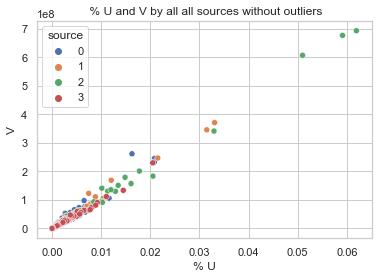

In [380]:
sns.scatterplot(data = data_without_outliers, hue = 'source', x='% U', y='V', palette="deep")
plt.title(' % U and V by all all sources without outliers')

### We would like to take a closer look- %U between 0 and 0.01

In [1166]:
data_closer = data.loc[data['% U'] < 0.01]

Text(0.5, 1.0, ' % U and V by all all sources- closer')

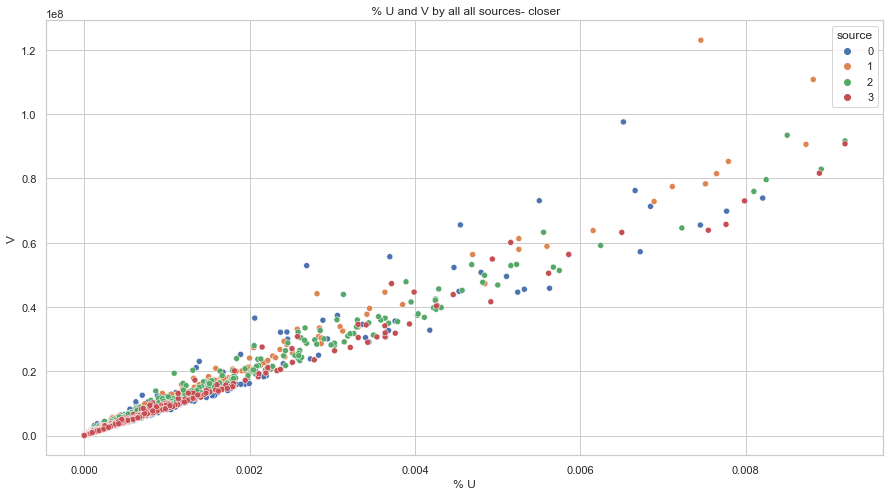

In [1167]:
sns.scatterplot(data = data_closer, hue = 'source', x='% U', y='V', palette="deep")
plt.title(' % U and V by all all sources- closer')

#### We would like to see for each source the scatter plot of the learning set vs the source

In [1168]:
data_without_outliers_1 = data_closer.loc[data_closer['source'].isin({0,1})]
data_without_outliers_2 = data_closer.loc[data_closer['source'].isin({0,2})]
data_without_outliers_3 = data_closer.loc[data_closer['source'].isin({0,3})]

### Scatter plot of % U and V for learning set and source 1, in a closer look

Text(0.5, 1.0, ' % U and V by learning set and source 1')

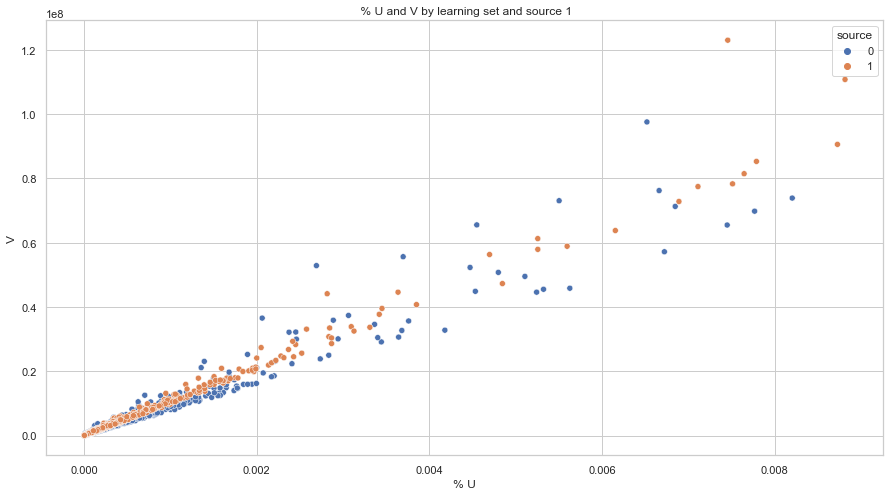

In [1169]:
sns.scatterplot(data = data_without_outliers_1, hue = 'source', x='% U', y='V', palette="deep")
plt.title(' % U and V by learning set and source 1')

### Scatter plot of % U and V for learning set and source 2, in a closer look

Text(0.5, 1.0, ' % U and V by learning set and source 2')

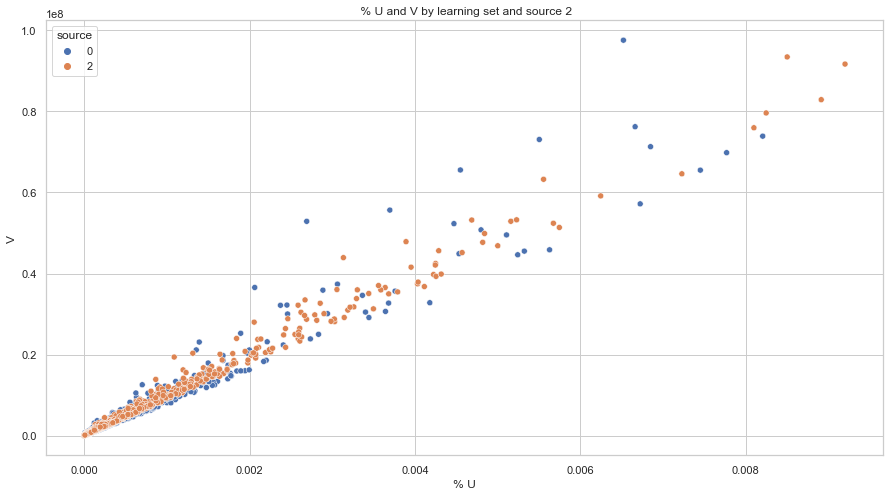

In [1170]:
sns.scatterplot(data = data_without_outliers_2, hue = 'source', x='% U', y='V', palette="deep")
plt.title(' % U and V by learning set and source 2')

### Scatter plot of % U and V for learning set and source 3, in a closer look

Text(0.5, 1.0, ' % U and V by learning set and source 3')

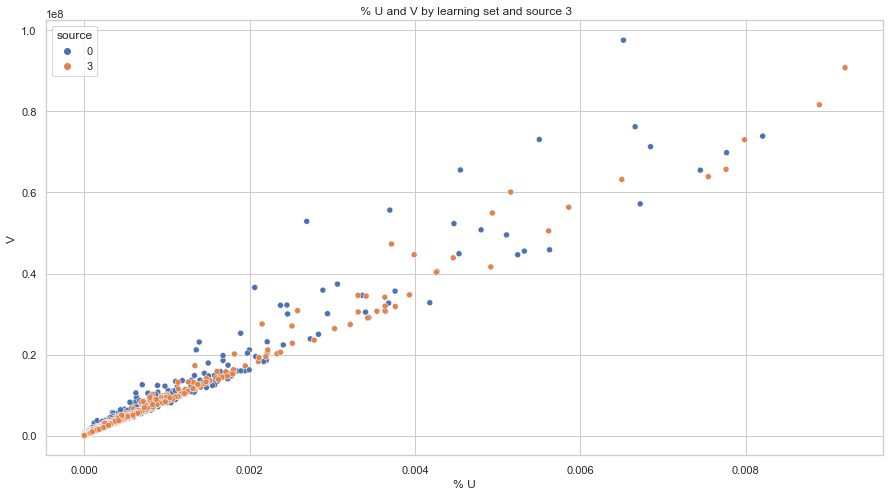

In [1171]:
sns.scatterplot(data = data_without_outliers_3, hue = 'source', x='% U', y='V', palette="deep")
plt.title(' % U and V by learning set and source 3')

#### We can see the relationship between V and % U for each source, and compare them to the relationship in the learning set. It seems that the closest relationship is source 1, then source 2, then source 3

#         

#### Create dataframes from the learning set which contain only the sites which are in the compared source

In [1603]:
data0_for1 = data0.loc[data0['site'].isin(data1['site'])]
data0_for2 = data0.loc[data0['site'].isin(data2['site'])]
data0_for3 = data0.loc[data0['site'].isin(data3['site'])]

#### Verified that each df contains same sites as each external source data, and different V, %U (but the same as data0)

In [1604]:
display(data0_for1.head(3))
display(data0_for2.head(3))
display(data0_for3.head(3))

,source,site,% U,V
0,0,06880danwoog.com*,0.0000033431,36280.0000000000
1,0,0800-horoscope.com*,0.0000107503,120690.0000000000
2,0,10000boatnames.com*,0.0000005871,6858.0000000000


,source,site,% U,V
0,0,06880danwoog.com*,0.0000033431,36280.0000000000
1,0,0800-horoscope.com*,0.0000107503,120690.0000000000
6,0,1015store.com*,0.0000228233,285488.0000000000


,source,site,% U,V
1,0,0800-horoscope.com*,0.0000107503,120690.0000000000
6,0,1015store.com*,0.0000228233,285488.0000000000
7,0,101kgb.com*,0.0000090153,76934.0000000000


#### Analyze the differences between V and % U of the learning set and sources 1-3 for each site which appears both in the learning set and in sources 1-3

In [1605]:
data1_with_V0_U0 = data1.copy() 

data1_with_V0_U0['V0'] = data0_for1['V'].values
data1_with_V0_U0['V0/V'] = data1_with_V0_U0['V0'] / data1_with_V0_U0['V']

data1_with_V0_U0['U0'] = data0_for1['% U'].values
data1_with_V0_U0['U0/U'] = data1_with_V0_U0['U0'] / data1_with_V0_U0['% U']

data1_with_V0_U0.head()

,source,site,% U,V,V0,V0/V,U0,U0/U
9699,1,06880danwoog.com*,0.0000050648,74508.9416692836,36280.0000000000,0.4869214243,0.0000033431,0.6600660066
9700,1,0800-horoscope.com*,0.0000079767,88514.4705800152,120690.0000000000,1.3635058676,0.0000107503,1.3477088949
9701,1,10000boatnames.com*,0.0000007662,7476.7074182638,6858.0000000000,0.9172486786,0.0000005871,0.7662835249
9702,1,100bestvacations.com*,0.0000010830,10568.1874182638,12891.0000000000,1.2197929020,0.0000015168,1.4005957767
9703,1,100stuartstreet.com*,0.0000019191,18726.7353686582,9758.0000000000,0.5210732041,0.0000011282,0.5878894768


In [1606]:
data2_with_V0_U0 = data2.copy()

data2_with_V0_U0['V0'] = data0_for2['V'].values
data2_with_V0_U0['V0/V'] = data2_with_V0_U0['V0'] / data2_with_V0_U0['V']

data2_with_V0_U0['U0'] = data0_for2['% U'].values
data2_with_V0_U0['U0/U'] = data2_with_V0_U0['U0'] / data2_with_V0_U0['% U']

data2_with_V0_U0.head()

,source,site,% U,V,V0,V0/V,U0,U0/U
18201,2,06880danwoog.com*,0.0000086720,77524.4506031888,36280.0000000000,0.4679813880,0.0000033431,0.3855063528
18202,2,0800-horoscope.com*,0.0000192860,172408.7952948560,120690.0000000000,0.7000222917,0.0000107503,0.5574127510
18203,2,1015store.com*,0.0000403516,360727.3543211320,285488.0000000000,0.7914232081,0.0000228233,0.5656108597
18204,2,101kgb.com*,0.0000144064,128787.7959416120,76934.0000000000,0.5973702666,0.0000090153,0.6257822278
18205,2,101science.com*,0.0000006500,5810.5367644285,6502.0000000000,1.1190016110,0.0000007080,1.0892307692


In [1607]:
data3_with_V0_U0 = data3.copy()

data3_with_V0_U0['V0'] = data0_for3['V'].values
data3_with_V0_U0['V0/V'] = data3_with_V0['V0'] / data3_with_V0['V']

data3_with_V0_U0['U0'] = data0_for3['% U'].values
data3_with_V0_U0['U0/U'] = data3_with_V0_U0['U0'] / data3_with_V0_U0['% U']
data3_with_V0_U0

,source,site,% U,V,V0,V0/V,U0,U0/U
24950,3,0800-horoscope.com*,0.0000087937,74442.3414620303,120690.0000000000,1.6212547541,0.0000107503,1.2224938875
24951,3,1015store.com*,0.0000134886,129225.5427621610,285488.0000000000,2.2092226807,0.0000228233,1.6920473773
24952,3,101kgb.com*,0.0000129910,109974.4146642270,76934.0000000000,0.6995627141,0.0000090153,0.6939647901
24953,3,101science.com*,0.0000008284,7012.7632342178,6502.0000000000,0.9271666222,0.0000007080,0.8546567770
24954,3,1035kissfm.com*,0.0000137343,116266.2841379230,156960.0000000000,1.3500044416,0.0000183859,1.3386880857
...,...,...,...,...,...,...,...,...
28359,3,zonebourse.com*,0.0000011568,11197.6040235910,7562.0000000000,0.6753230409,0.0000009435,0.8156606852
28360,3,zoochat.com*,0.0000033723,28548.0562232387,32034.0000000000,1.1221079204,0.0000025861,0.7668711656
28361,3,zvents.com*,0.0000808304,684262.0951674310,740008.0000000000,1.0814686437,0.0000938797,1.1614401858
28362,3,zybez.net*,0.0000980263,923140.2023787440,1237033.0000000000,1.3400272210,0.0000762851,0.7782101167


#### Scatter plot of V0-V1-3. It seems that for small values of V there can be really high errors, since the V0/V ratio which is optimally = 1, can get high.

#### Source1

Text(0.5, 1.0, 'V0/V1 ratio of learning set and source 1')

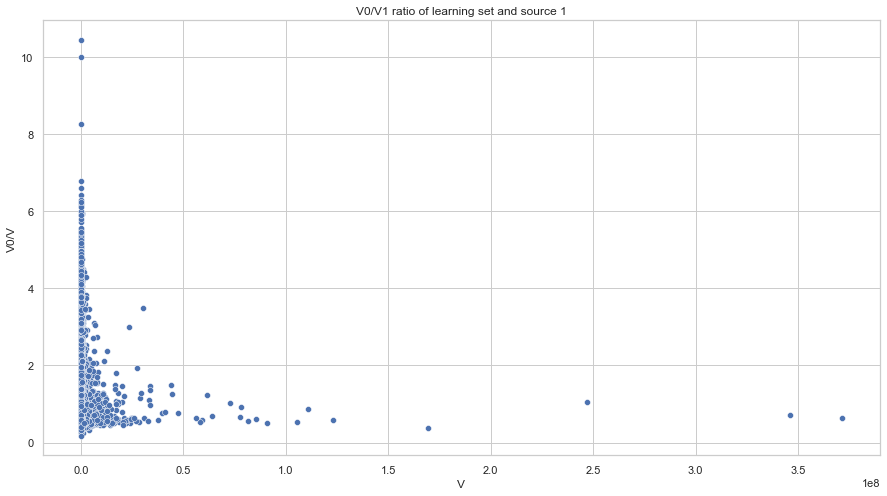

In [1609]:
sns.scatterplot(data = data1_with_V0_U0, x='V', y='V0/V', palette="deep")
plt.title('V0/V1 ratio of learning set and source 1')

#### Source2

Text(0.5, 1.0, 'V0/V2 ratio of learning set and source 2')

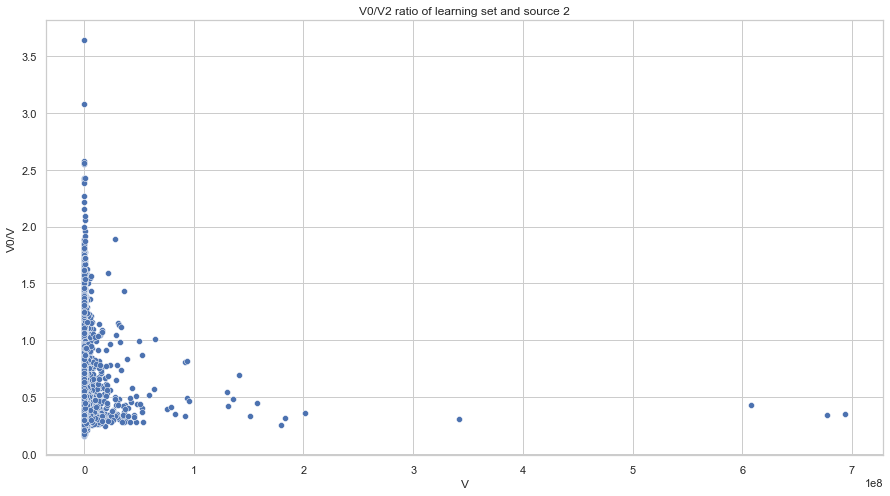

In [1613]:
sns.scatterplot(data = data2_with_V0_U0, x='V', y='V0/V', palette="deep")
plt.title('V0/V2 ratio of learning set and source 2')

#### Source3

Text(0.5, 1.0, 'V0/V3 ratio of learning set and source 3')

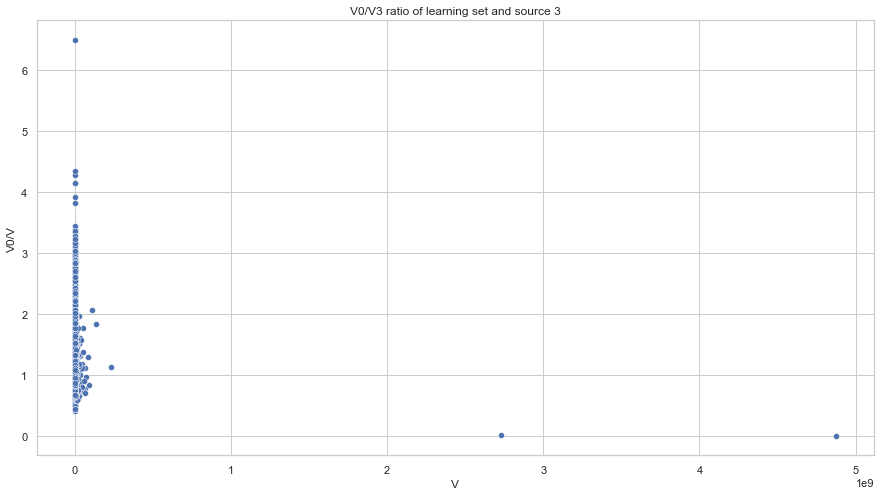

In [1612]:
sns.scatterplot(data = data3_with_V0_U0, x='V', y='V0/V', palette="deep")
plt.title('V0/V3 ratio of learning set and source 3')

#### There are outliers, let's take a closer look at the smaller V values

In [1615]:
data1_small = data1_with_V0_U0.loc[data1_with_V0_U0['V0'] < 10000]
data2_small = data2_with_V0_U0.loc[data2_with_V0_U0['V0'] < 10000]
data3_small = data3_with_V0_U0.loc[data3_with_V0_U0['V0'] < 10000]

#### In the closer look we can see that the ratios between the V values of the learning set and source1-3  is high for V values which are less than 6000, and then increase as V increases.

### Source1:

#### We can see that for V<6000 the V0/V which is optimal value is 1, is high for the lower values of V. If we look at the high values of V>20,000 - the ration V0/V is lower than 0.5. 
#### It seems that source 1 can fit all the mid values between 6K-20K

Text(0.5, 1.0, 'V0/V1 ratio of learning set and source 1 for V small values')

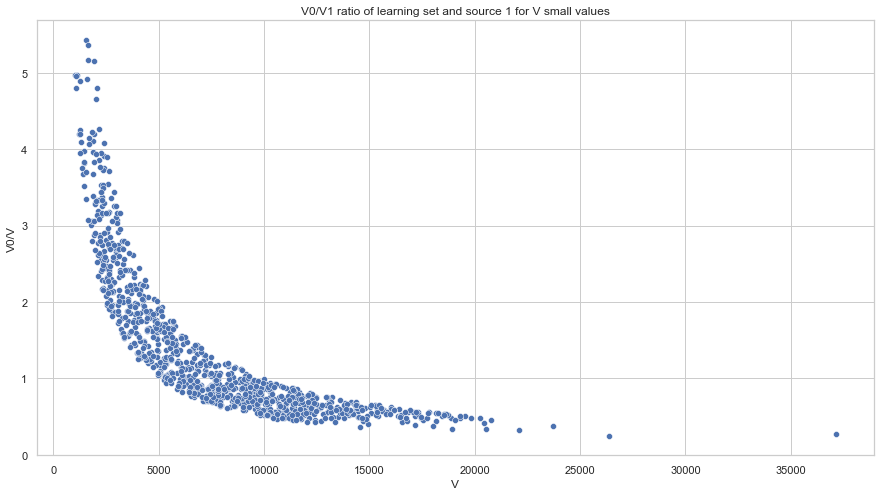

In [1616]:
sns.scatterplot(data = data1_small, x='V', y='V0/V', palette="deep")
plt.title('V0/V1 ratio of learning set and source 1 for V small values')

#### source 2

#### We can see that for V<6000 the V0/V are lower than source1 for the lower values of V. If we look at the high values of V>20,000 - the ration V0/V is even lower than source1. 
#### It seems that source 2 can fit better for all the small values below 6K.

Text(0.5, 1.0, 'V0/V2 ratio of learning set and source 2 for V small values')

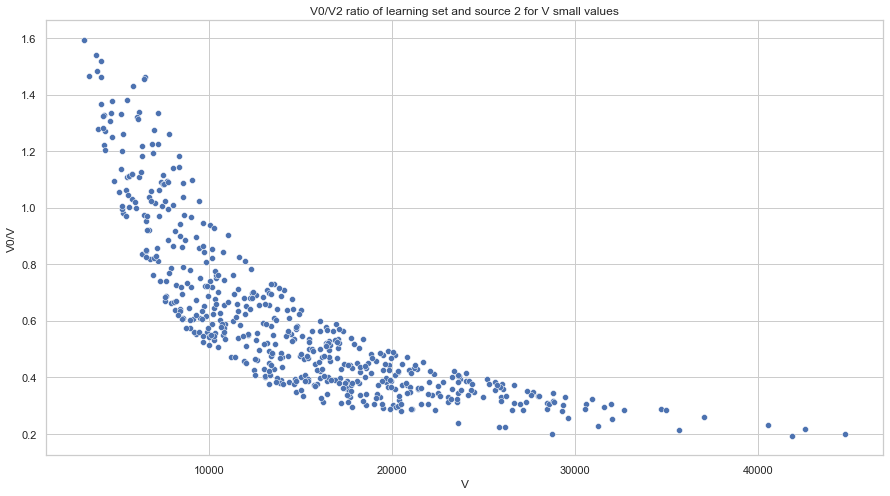

In [1617]:
sns.scatterplot(data = data2_small, x='V', y='V0/V', palette="deep")
plt.title('V0/V2 ratio of learning set and source 2 for V small values')

#### source 3

#### We can see that for V<6000 the V0/V is higher than source1 for the lower values of V. If we look at the high values of V>20,000 - the ration V0/V is higher than source1. 
#### It seems that source 3 can fit better for all the big values above 10K

Text(0.5, 1.0, 'V0/V3 ratio of learning set and source 3 for V small values')

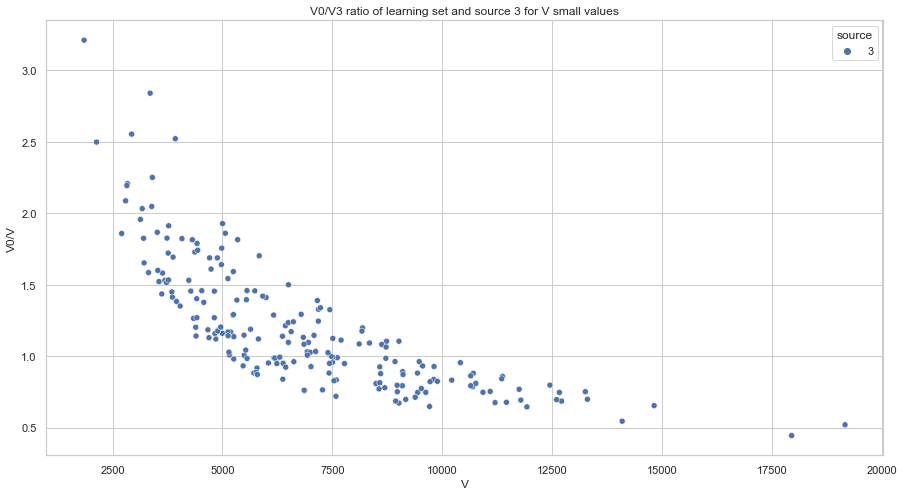

In [1618]:
sns.scatterplot(data = data3_small, hue = 'source', x='V', y='V0/V', palette="deep")
plt.title('V0/V3 ratio of learning set and source 3 for V small values')

### In general regarding to all 3 external sources- it seems that for small V values the % of error has a high degree of varience compared to higher V values. (until 6k=v) and then the % error increase again as V increases

####          

### Same graphs for % U in all 3 sources:

#### source 1

Text(0.5, 1.0, 'V0/V1 ratio of learning set and source 1 for V small values')

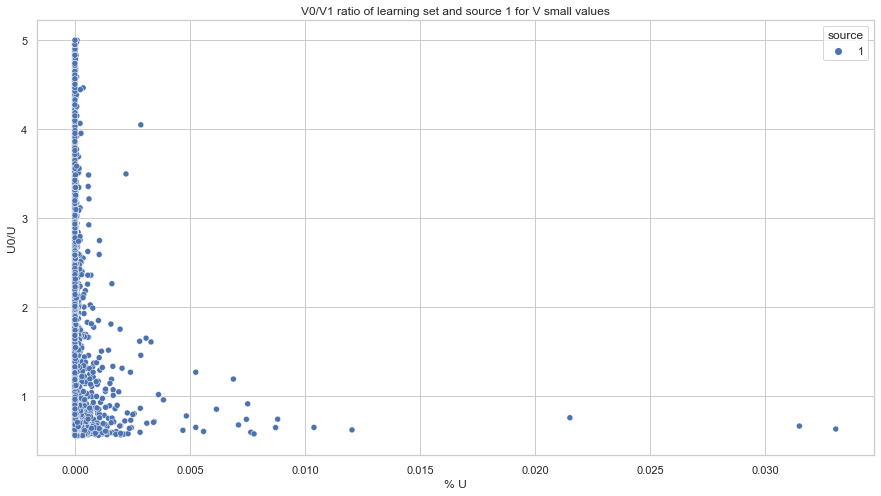

In [1624]:
sns.scatterplot(data = data1_with_V0_U0, hue = 'source', x='% U', y='U0/U', palette="deep")
plt.title('V0/V1 ratio of learning set and source 1 for V small values')

#### Source2

Text(0.5, 1.0, 'V0/V2 ratio of learning set and source 2 for V small values')

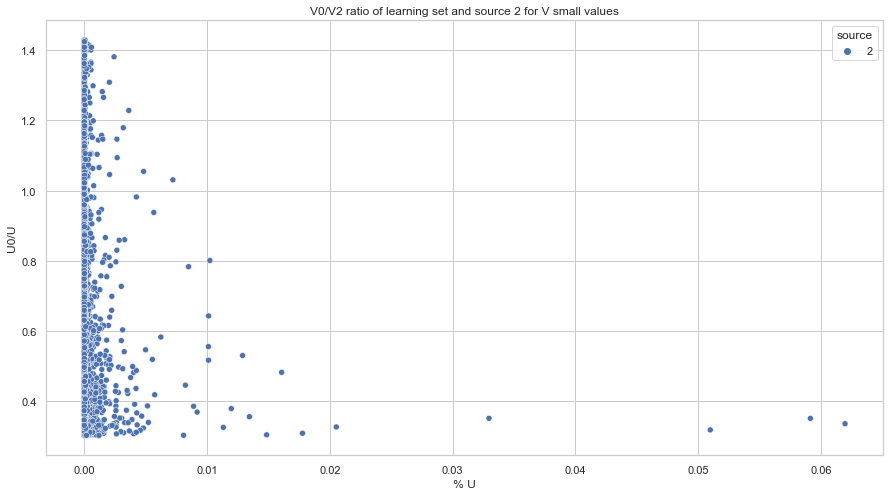

In [1625]:
sns.scatterplot(data = data2_with_V0_U0, hue = 'source', x='% U', y='U0/U', palette="deep")
plt.title('V0/V2 ratio of learning set and source 2 for V small values')

#### Source3

Text(0.5, 1.0, 'V0/V3 ratio of learning set and source 3 for V small values')

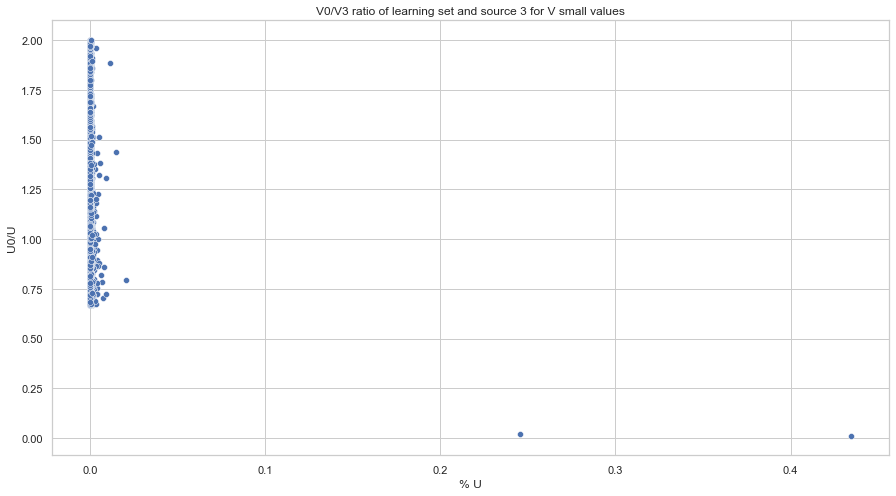

In [1626]:
sns.scatterplot(data = data3_with_V0_U0, x='% U', y='U0/U', palette="deep")
plt.title('V0/V3 ratio of learning set and source 3 for V small values')

#### Similar results to V- when  %U is close to zero, the error can get high.

#### Again, there are ouliers, let's take a closer look

In [1654]:
data1_small_u = data1_with_V0_U0.loc[data1_with_V0_U0['% U'] < 0.001]
data2_small_u = data2_with_V0_U0.loc[data2_with_V0_U0['% U'] < 0.001]
data3_small_u = data3_with_V0_U0.loc[data3_with_V0_U0['% U'] < 0.001]

#### source 1

### For all external sources it seams that for observations with %U lower than 0.00001 the ratio can get high, but the data spread more uniformly than in the V's graphs.

Text(0.5, 1.0, 'V0/V1 ratio of learning set and source 1 for V small values')

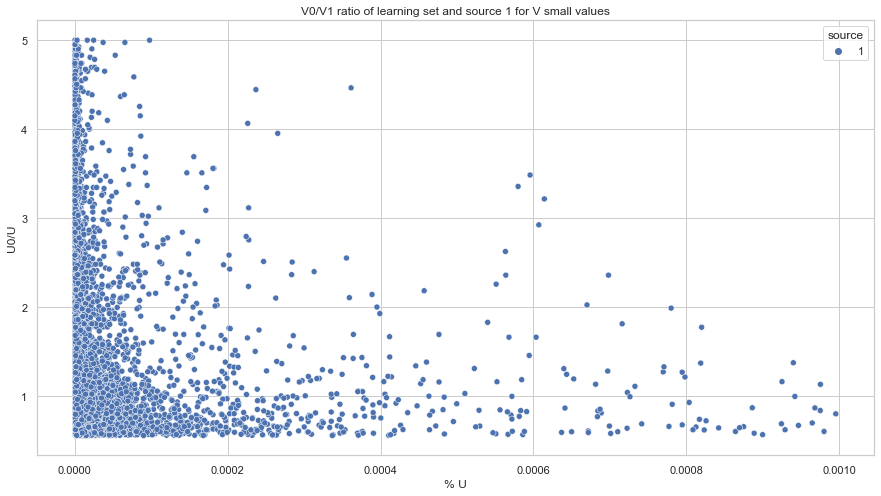

In [1655]:
sns.scatterplot(data = data1_small_u, hue = 'source', x='% U', y='U0/U', palette="deep")
plt.title('V0/V1 ratio of learning set and source 1 for V small values')

#### Source2

Text(0.5, 1.0, 'V0/V2 ratio of learning set and source 2 for V small values')

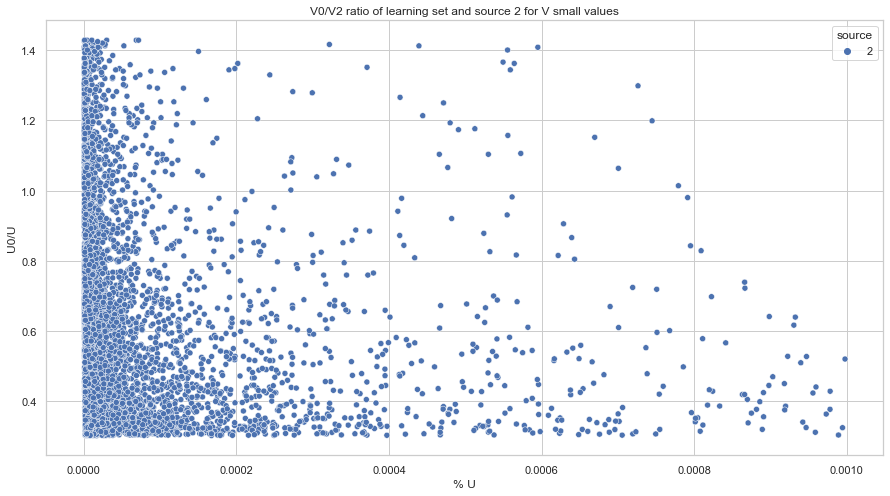

In [1656]:
sns.scatterplot(data = data2_small_u, hue = 'source', x='% U', y='U0/U', palette="deep")
plt.title('V0/V2 ratio of learning set and source 2 for V small values')

#### Source3

Text(0.5, 1.0, 'V0/V3 ratio of learning set and source 3 for V small values')

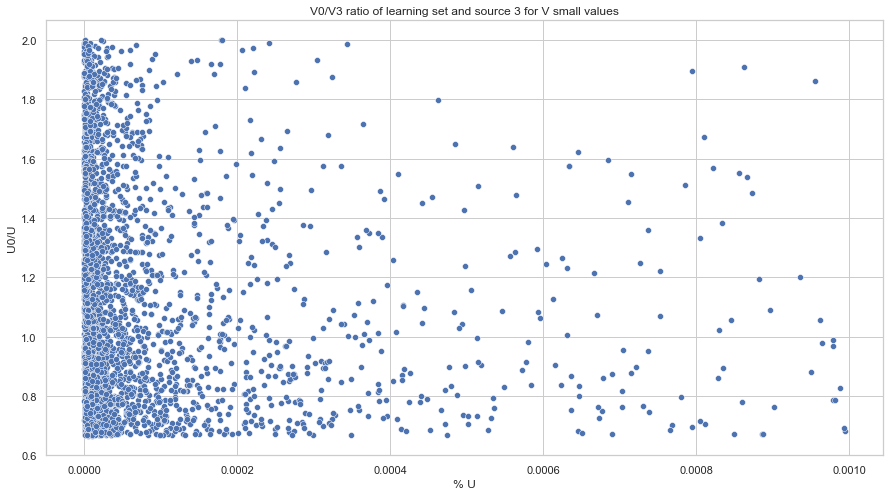

In [1657]:
sns.scatterplot(data = data3_small_u, x='% U', y='U0/U', palette="deep")
plt.title('V0/V3 ratio of learning set and source 3 for V small values')

## Analyze different metrics for the relationship between the External Sources and the Learning Set

### We will use Mean, Median, and Std for the diffrerence in % U, V, and %U * V, for the dataset, the dataset without ouliers, and the dataset while we compare for each external source and the learning set only by the same sites (we will use only the sites which are relevant to each external source in the learning set)

#### A function which plots 3 bar plot per type- with_outliers, Without_outliers, and common- (use items from the learning set which contain only the sites which are in the compared external source). For each source. The height represents the distance of the source from the learning set

In [233]:
def plot_three_types_of_data(data_with_outliers, data_without_outliers, data_common):
    
    index = ['Source 1', 'Source 2', 'Source 3']
    df = pd.DataFrame({'With_outliers': data_with_outliers,
                       'Without_outliers': data_without_outliers,
                        'Common': data_common}, index=index)

    axes = df.plot.bar(
        rot=0, subplots=True)
    axes[1].legend(loc=2) 

#### Create dataframes without outliers. The outliers are 8 observations from sources 1-3 (none of them from the learning set)

In [226]:
data_no_outliers = data.loc[data['% U'] < 0.03]
data_01_no_outliers = data_no_outliers.loc[data_no_outliers['source'].isin({0,1})]
data_02_no_outliers = data_no_outliers.loc[data_no_outliers['source'].isin({0,2})]
data_03_no_outliers = data_no_outliers.loc[data_no_outliers['source'].isin({0,3})]

## Mean

### Difference between 'V' averages
#### Calculate for each external source the absulote value of the difference in 'V' mean between the learning set and the source

In [326]:
data0_V_mean = data0['V'].mean()
data1_V_mean = data1['V'].mean()
data2_V_mean = data2['V'].mean()
data3_V_mean = data3['V'].mean()

In [1250]:
dif_avg_V1 = abs(data0_V_mean / data1_V_mean)
dif_avg_V2 = abs(data0_V_mean / data2_V_mean)
dif_avg_V3 = abs(data0_V_mean / data3_V_mean)

dif_avg_V = [dif_avg_V1, dif_avg_V2, dif_avg_V3]
display(dif_avg_V)

[0.24049574333325768, 1.8199066787641174, 4.6027632042902855]

#### With outliers - source 1 is the closests, then source 2 and then source 3

In [579]:
dif_avg_V1_no_outliers = abs(data0_V_mean / data_01_no_outliers['V'].mean())
dif_avg_V2_no_outliers = abs(data0_V_mean / data_02_no_outliers['V'].mean())
dif_avg_V3_no_outliers = abs(data0_V_mean / data_03_no_outliers['V'].mean())

dif_avg_V_no_outliers = [dif_avg_V1_no_outliers, dif_avg_V2_no_outliers, dif_avg_V3_no_outliers]
display(dif_avg_V_no_outliers)

[0.9507888222305638, 0.6536596039217304, 0.7659332090719424]

#### Without outliers - source 1 is the closests, then source 3 and then source 2. Mean is sensitive to outliers, we remember that there were 2 distant outliers from source 3, after removing them the distance by mean of source 3 is less than source 2.

In [580]:
dif_avg_V_1_common = abs(data0_for1['V'].mean() / data1_V_mean)
dif_avg_V_2_common = abs(data0_for2['V'].mean() / data2_V_mean)
dif_avg_V_3_common = abs(data0_for3['V'].mean() / data3_V_mean)

dif_avg_V_common = [dif_avg_V_1_common, dif_avg_V_2_common, dif_avg_V_3_common]
display(dif_avg_V_common)

[0.9088129131975418, 0.4947045807817646, 0.4578634637324638]

#### Data0 with only common sites - source 1 is the closests, then source 2 and then source 3

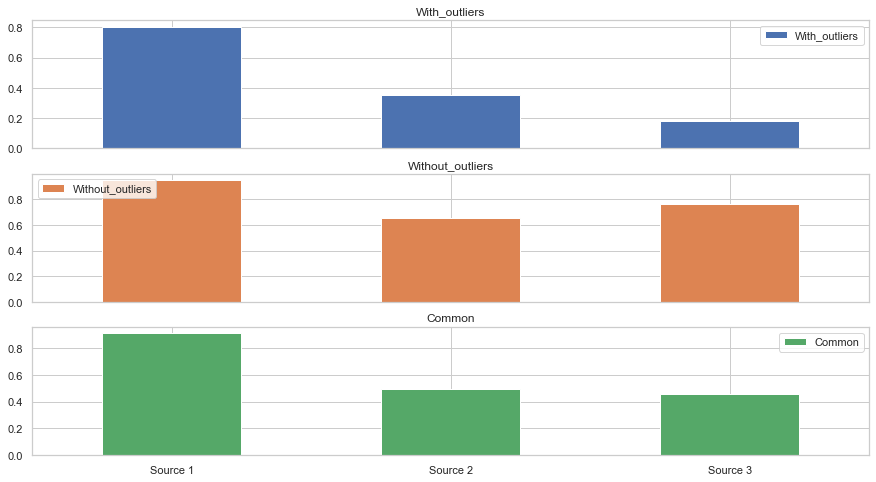

In [581]:
plot_three_types_of_data(dif_avg_V, dif_avg_V_no_outliers, dif_avg_V_common)

#### Ploting all 3 bar plots of mean V distances from the learning set. We can see similar results between "with outliers", and "Common", while in "Without outliers" source 2 has a higher distance than source 3, due to the outlier deletion and that mean is sensitive for outliers.
###    

### Difference between '% U' averages
#### Calculate for each external source (1-3) the absulote value of the difference in '% U' mean between the learning set and the source


In [582]:
data0_U_mean = data0['% U'].mean()
data1_U_mean = data1['% U'].mean()
data2_U_mean = data2['% U'].mean()
data3_U_mean = data3['% U'].mean()

In [583]:
dif_avg_U1 = abs(data0_U_mean / data1_U_mean)
dif_avg_U2 = abs(data0_U_mean / data2_U_mean)
dif_avg_U3 = abs(data0_U_mean / data3_U_mean)

dif_avg_U = [dif_avg_U1, dif_avg_U2, dif_avg_U3]
display(dif_avg_U)

[0.8570742569150206, 0.35122487877470626, 0.17807948704036683]

#### With outliers - source 1 is the closests, then source 2 and then source 3

In [584]:
dif_avg_U1_no_outliers = abs(data0_U_mean / data_01_no_outliers['% U'].mean())
dif_avg_U2_no_outliers = abs(data0_U_mean / data_02_no_outliers['% U'].mean())
dif_avg_U3_no_outliers = abs(data0_U_mean / data_03_no_outliers['% U'].mean())

dif_avg_U_no_outliers = [dif_avg_U1_no_outliers, dif_avg_U2_no_outliers, dif_avg_U3_no_outliers]
display(dif_avg_U_no_outliers)

[0.9792068346395072, 0.641493469368429, 0.728834230611488]

#### Without outliers - source 1 is the closests, then source 3 and then source 2.    Mean is sensitive to outliers, we remember that there were 2 distant outliers from source 3, after removing them the distance by mean of source 3 is less than source 2.

In [585]:
dif_avg_U_1_common = abs(data0_for1['% U'].mean() / data1_U_mean)
dif_avg_U_2_common = abs(data0_for2['% U'].mean() / data2_U_mean)
dif_avg_U_3_common = abs(data0_for3['% U'].mean() / data3_U_mean)

dif_avg_U_common = [dif_avg_U_1_common, dif_avg_U_2_common, dif_avg_U_3_common]
display(dif_avg_U_common)

[0.9668007545567606, 0.4898169630202942, 0.45750219192890573]

#### Data0 with only common sites - source 1 is the closests, then source 2 and then source 3

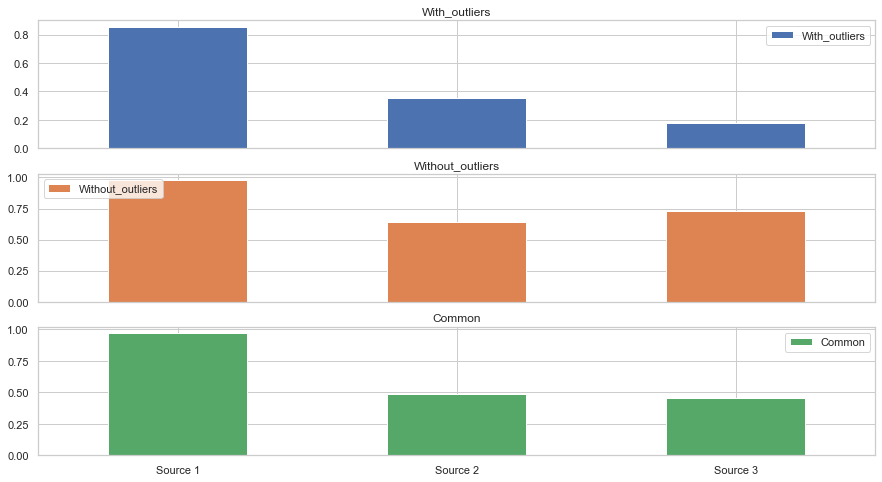

In [586]:
plot_three_types_of_data(dif_avg_U, dif_avg_U_no_outliers, dif_avg_U_common)

#### Ploting all 3 bar plots of mean % U distances from the learning set. We can see similar results between "with outliers", and "Common", while in "Without outliers" source 2 has a higher distance than source 3, due to the outlier deletion and that mean is sensitive for outliers.
###    

### (We will not use a metric of the difference between 'V' + % U' of mean, median and std, since is almost the same as Difference between 'V' since 'V' values are significantly much larger than %U values)
###     

### Difference between 'V' * '% U' averages. %U * V = % of unique users * the traffic
#### Calculate for each external source (1-3) the absulote value of the difference in % U * V mean between the learning set and the source

In [587]:
data0_avg_VmulU = (data0['V'] * data0['% U']).mean()
data1_avg_VmulU = (data1['V'] * data1['% U']).mean()
data2_avg_VmulU = (data2['V'] * data2['% U']).mean()
data3_avg_VmulU = (data3['V'] * data3['% U']).mean()

In [588]:
dif_avg_VmulU1 = abs(data0_avg_VmulU / data1_avg_VmulU)
dif_avg_VmulU2 = abs(data0_avg_VmulU / data2_avg_VmulU)
dif_avg_VmulU3 = abs(data0_avg_VmulU / data3_avg_VmulU)

dif_avg_VmulU = [dif_avg_VmulU1, dif_avg_VmulU2, dif_avg_VmulU3]
display(dif_avg_VmulU)


[0.5191120488059022, 0.1081366220289459, 0.003226484346477103]

#### With outliers - source 1 is the closests, then source 2 and then source 3

In [589]:
dif_avg_VmulU1_no_outliers = abs(data0_avg_VmulU / (data_01_no_outliers['V'] * data_01_no_outliers['% U']).mean())
dif_avg_VmulU2_no_outliers = abs(data0_avg_VmulU / (data_02_no_outliers['V'] * data_02_no_outliers['% U']).mean())
dif_avg_VmulU3_no_outliers = abs(data0_avg_VmulU / (data_03_no_outliers['V'] * data_03_no_outliers['% U']).mean())

dif_avg_VmulU_no_outliers = [dif_avg_VmulU1_no_outliers, dif_avg_VmulU2_no_outliers, dif_avg_VmulU3_no_outliers]
display(dif_avg_VmulU_no_outliers)

[1.049993664754973, 0.6615605787021137, 0.8063435172406623]

#### Without outliers - source 1 is the closests, then source 3 and then source 2.    Mean is sensitive to outliers, we remember that there were 2 distant outliers from source 3, after removing them the distance by mean of source 3 is less than source 2.

In [590]:
dif_avg_VmulU1_common = abs((data0_for1['V'] * data0_for1['% U']).mean() / data1_avg_VmulU)
dif_avg_VmulU2_common = abs((data0_for2['V'] * data0_for2['% U']).mean() / data2_avg_VmulU)
dif_avg_VmulU3_common = abs((data0_for3['V'] * data0_for3['% U']).mean() / data3_avg_VmulU)

dif_avg_VmulU_common = [dif_avg_VmulU1_common, dif_avg_VmulU2_common, dif_avg_VmulU3_common]
display(dif_avg_VmulU_common)

[0.5903427111749056, 0.15478053404296402, 0.00909392948103917]

#### Data0 with only common sites - source 1 is the closests, then source 2 and then source 3

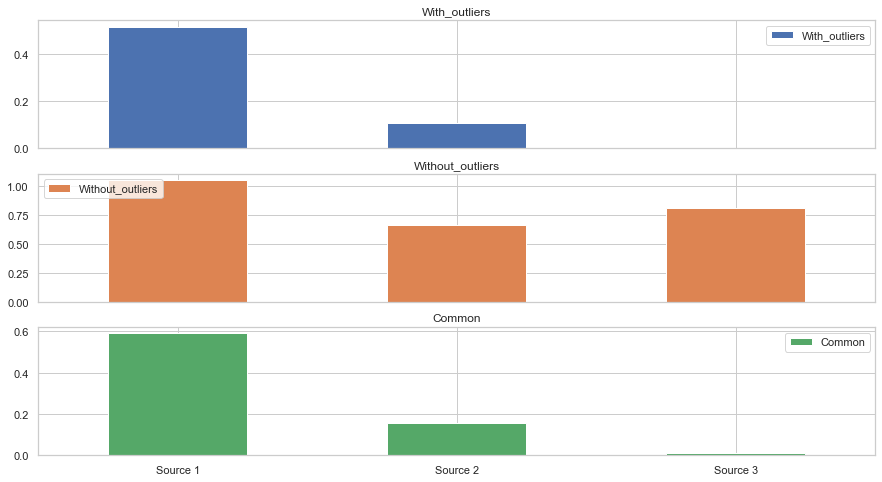

In [591]:
plot_three_types_of_data(dif_avg_VmulU, dif_avg_VmulU_no_outliers, dif_avg_VmulU_common)

#### Ploting all 3 bar plots of mean % U * V distances from the learning set. We can see similar results between "with outliers", and "Common"- where there is extremely different result between source1-2 and source3, while in "Without outliers" source 2 has a higher distance than source 3, due to the outlier deletion and that mean is sensitive for outliers.
###    

## Median - less sensitive to outliers than Mean

### Difference between 'V' median
#### Calculate for each external source the absulote value of the difference in 'V' mean between the learning set and the source

In [592]:
data0_V_median = data0['V'].median()
data1_V_median = data1['V'].median()
data2_V_median = data2['V'].median()
data3_V_median = data3['V'].median()

In [593]:
dif_median_V1 = abs(data0_V_median / data1_V_median)
dif_median_V2 = abs(data0_V_median / data2_V_median)
dif_median_V3 = abs(data0_V_median / data3_V_median)

dif_median_V = [dif_median_V1, dif_median_V2, dif_median_V3]
display(dif_median_V)

[0.7915335042858052, 0.28809268352233175, 0.2646817213452169]

#### With outliers - source 1 is the closests, then source 2 and then source 3. Source 2 and source 3 has close distances to the learning set.

In [594]:
dif_median_V1_no_outliers = abs(data0_V_median  / data_01_no_outliers['V'].median())
dif_median_V2_no_outliers = abs(data0_V_median  / data_02_no_outliers['V'].median())
dif_median_V3_no_outliers = abs(data0_V_median  / data_03_no_outliers['V'].median())

dif_median_V_no_outliers = [dif_median_V1_no_outliers, dif_median_V2_no_outliers, dif_median_V3_no_outliers]
display(dif_median_V_no_outliers)

[0.8911859421853606, 0.5923207341884378, 0.7502856464560776]

#### Without outliers - source 1 is the closests, then source 3 and then source 2.  

In [595]:
dif_median_V_1_common = abs(data0_for1['V'].median() / data1_V_median)
dif_median_V_2_common = abs(data0_for2['V'].median() / data2_V_median)
dif_median_V_3_common = abs(data0_for3['V'].median() / data3_V_median)

dif_median_V_common = [dif_median_V_1_common, dif_median_V_2_common, dif_median_V_3_common]
display(dif_median_V_common)

[1.008049957570053, 0.5481069079029676, 1.233987369759898]

#### Data0 with only common sites - source 1 is the closests, then source 3 and then source 2

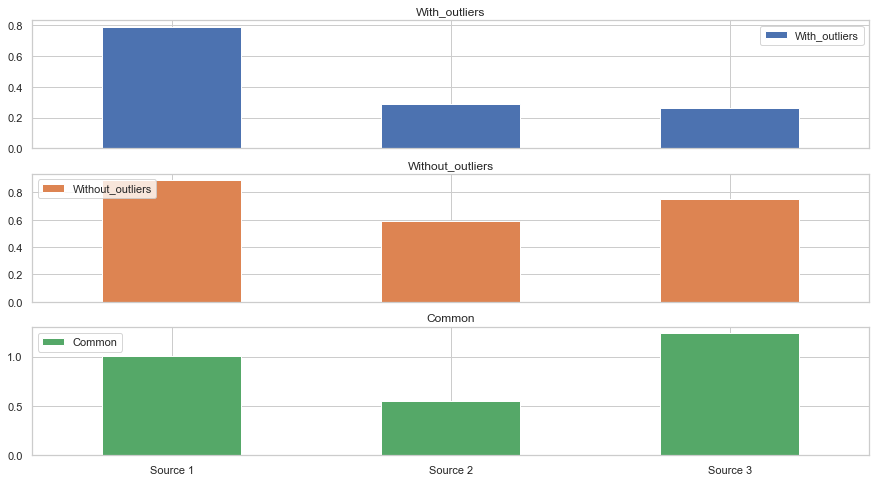

In [596]:
plot_three_types_of_data(dif_median_V, dif_median_V_no_outliers, dif_median_V_common)

#### Ploting all 3 bar plots of Median V distances from the learning set. We can see similar results between "without outliers", and "Common"- where source2 has higher distance than source3, while in "With outliers" source 3 has a higher distance than source 2
###    

### Difference between '% U' median
#### Calculate for each external source the absulote value of the difference in '% U' median between the learning set and the source

In [597]:
data0_U_median = data0['% U'].median()
data1_U_median = data1['% U'].median()
data2_U_median = data2['% U'].median()
data3_U_median = data3['% U'].median()

In [598]:
dif_median_U1 = abs(data0_U_median / data1_U_median)
dif_median_U2 = abs(data0_U_median / data2_U_median)
dif_median_U3 = abs(data0_U_median / data3_U_median)

dif_median_U = [dif_median_U1, dif_median_U2, dif_median_U3]
display(dif_median_U)

[0.8567719051826573, 0.2764062463897855, 0.2409199577329014]

#### With outliers - source 1 is the closests, then source 2 and then source 3. Source 2 and source 3 has close distances to the learning set.

In [599]:
dif_median_U1_no_outliers = abs(data0_U_median / data_01_no_outliers['% U'].median())
dif_median_U2_no_outliers = abs(data0_U_median / data_02_no_outliers['% U'].median())
dif_median_U3_no_outliers = abs(data0_U_median / data_03_no_outliers['% U'].median())

dif_median_U_no_outliers = [dif_median_U1_no_outliers, dif_median_U2_no_outliers, dif_median_U3_no_outliers]
display(dif_median_U_no_outliers)

[0.9305900710859392, 0.5846363613208839, 0.7361078500859829]

#### Without outliers - source 1 is the closests, then source 3 and then source 2.  

In [600]:
dif_median_U_1_common = abs(data0_for1['% U'].median() / data1_U_median)
dif_median_U_2_common = abs(data0_for2['% U'].median() / data2_U_median)
dif_median_U_3_common = abs(data0_for3['% U'].median() / data3_U_median)

dif_median_U_common = [dif_median_U_1_common, dif_median_U_2_common, dif_median_U_3_common]
display(dif_median_U_common)

[1.0902348516207467, 0.5180085141088909, 1.0716688878771508]

#### Data0 with only common sites - source 1 is the closests, then source 3 and then source 2

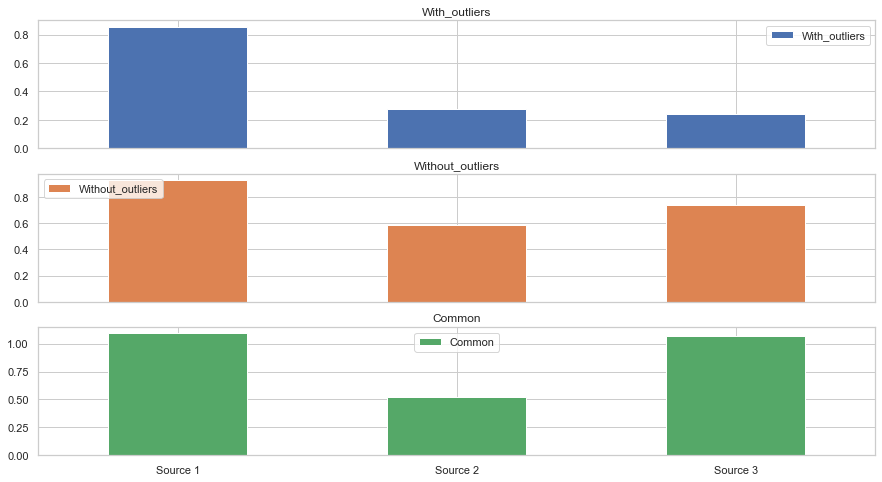

In [601]:
plot_three_types_of_data(dif_median_U, dif_median_U_no_outliers, dif_median_U_common)

#### Ploting all 3 bar plots of Median %U distances from the learning set. We can see similar results between "without outliers", and "Common"- where source2 has higher distance than source3, while in "With outliers" source 3 has a higher distance than source 2
###    

### Difference between 'V' * '% U' medians
#### Calculate for each external source (1-3) the absulote value of the difference in % U * V median between the learning set and the source

In [602]:
data_0_median_VmulU1 = (data0['V'] * data0['% U']).median()
data_1_median_VmulU1 = (data1['V'] * data1['% U']).median()
data_2_median_VmulU1 = (data2['V'] * data2['% U']).median()
data_3_median_VmulU1 = (data3['V'] * data3['% U']).median()

In [603]:
dif_median_VmulU1 = abs(data_0_median_VmulU1 / data_1_median_VmulU1)
dif_median_VmulU2 = abs(data_0_median_VmulU1 / data_2_median_VmulU1)
dif_median_VmulU3 = abs(data_0_median_VmulU1 / data_3_median_VmulU1)

dif_median_VmulU = [dif_median_VmulU1, dif_median_VmulU2, dif_median_VmulU3]
display(dif_median_VmulU)

[0.6712781347214224, 0.07893236489166819, 0.06384598854781565]

#### With outliers - source 1 is the closests, then source 2 and then source 3. Source 2 and source 3 has close distances to the learning set.

In [604]:
dif_median_VmulU1_no_outliers = abs(data_0_median_VmulU1 / (data_01_no_outliers['V'] * data_01_no_outliers['% U']).median())
dif_median_VmulU2_no_outliers = abs(data_0_median_VmulU1 / (data_02_no_outliers['V'] * data_02_no_outliers['% U']).median())
dif_median_VmulU3_no_outliers = abs(data_0_median_VmulU1 / (data_03_no_outliers['V'] * data_03_no_outliers['% U']).median())

dif_median_VmulU_no_outliers = [dif_median_VmulU1_no_outliers, dif_median_VmulU2_no_outliers, dif_median_VmulU3_no_outliers]
display(dif_median_VmulU_no_outliers)

[0.8185193411426719, 0.339822212272992, 0.5462548926740421]

#### Without outliers - source 1 is the closests, then source 3 and then source 2.  

In [605]:
dif_median_VmulU1_common = abs((data0_for1['V'] * data0_for1['% U']).median() / data_1_median_VmulU1)
dif_median_VmulU2_common = abs((data0_for2['V'] * data0_for2['% U']).median() / data_2_median_VmulU1)
dif_median_VmulU3_common = abs((data0_for3['V'] * data0_for3['% U']).median() / data_3_median_VmulU1)

dif_median_VmulU_common = [dif_median_VmulU1_common, dif_median_VmulU2_common, dif_median_VmulU3_common]
display(dif_median_VmulU_common)

[1.1044351118072935, 0.28633392161267024, 1.3118497155648123]

#### Data0 with only common sites - source 1 is the closests, then source 3 and then source 2

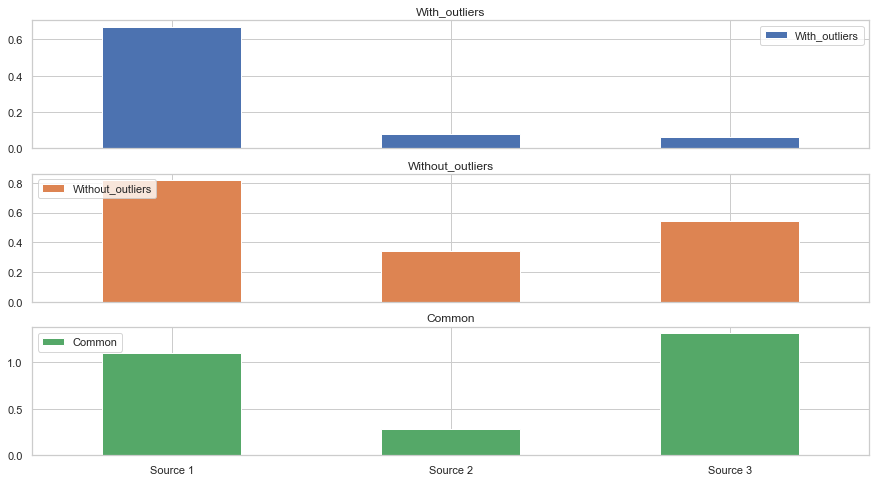

In [606]:
plot_three_types_of_data(dif_median_VmulU, dif_median_VmulU_no_outliers, dif_median_VmulU_common)

#### Ploting all 3 bar plots of Median %U * V distances from the learning set. We can see similar results between "without outliers", and "Common"- where source2 has higher distance than source3, while in "With outliers" source 3 has a higher distance than source 2
###    

## Std

### Difference between 'V' Std
#### Calculate for each external source the absulote value of the difference in 'V' Std between the learning set and the source

In [607]:
data0_v_std = data0['V'].std()
data1_v_std = data1['V'].std()
data2_v_std = data2['V'].std()
data3_v_std = data3['V'].std()

In [608]:
dif_std_V1 = abs(data0_v_std / data1_v_std)
dif_std_V2 = abs(data0_v_std / data2_v_std)
dif_std_V3 = abs(data0_v_std / data3_v_std)

dif_std_V = [dif_std_V1, dif_std_V2, dif_std_V3]
display(dif_std_V)

[0.7335828305032205, 0.338188543049058, 0.058019285852648705]

#### With outliers - source 1 is the closests, then source 2 and then source 3. Source 1 and source 2 has close distances to the learning set.

In [609]:
dif_std_V1_no_outliers = abs(data0_v_std / data_01_no_outliers['V'].std())
dif_std_V2_no_outliers = abs(data0_v_std / data_02_no_outliers['V'].std())
dif_std_V3_no_outliers = abs(data0_v_std / data_03_no_outliers['V'].std())

dif_std_V_no_outliers = [dif_std_V1_no_outliers, dif_std_V2_no_outliers, dif_std_V3_no_outliers]
display(dif_std_V_no_outliers)

[1.0288006240783678, 0.8477529896116623, 0.9307085854960094]

#### Without outliers - source 1 is the closests, then source 3 and then source 2.  

In [610]:
dif_std_V_1_common = abs(data0_for1['V'].std() / data1_v_std)
dif_std_V_2_common = abs(data0_for2['V'].std() / data2_v_std)
dif_std_V_3_common = abs(data0_for3['V'].std() / data3_v_std)

dif_std_V_common = [dif_std_V_1_common, dif_std_V_2_common, dif_std_V_3_common]
display(dif_std_V_common)

[0.7815129662561832, 0.40357584086314274, 0.09651335910825756]

#### Data0 with only common sites - source 1 is the closests, then source 2 and then source 3

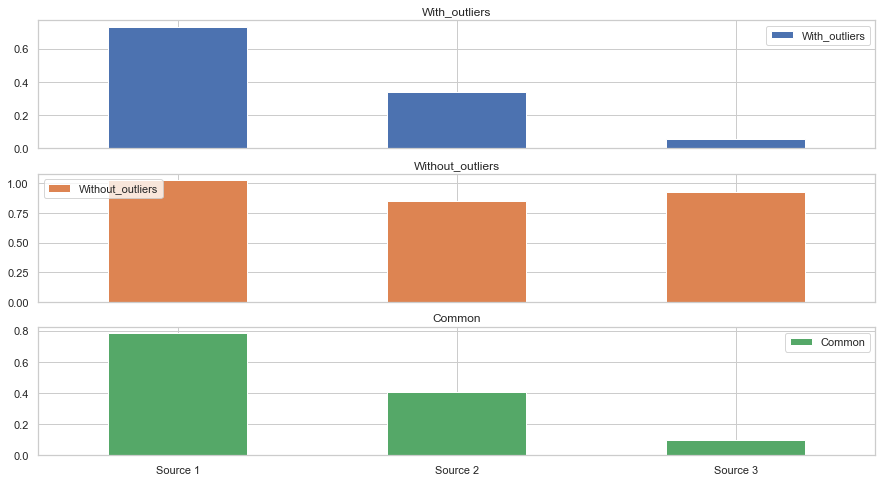

In [611]:
plot_three_types_of_data(dif_std_V, dif_std_V_no_outliers, dif_std_V_common)

#### Ploting all 3 bar plots of Std V distances from the learning set. We can see similar results between "with outliers", and "Common"- where source3 has higher distance than source2, while in "Without outliers" source 2 has a higher distance than source 3
###    

### Difference between %U Std
#### Calculate for each external source the absulote value of the difference in '%U' Std between the learning set and the source

In [612]:
data0_U_std = data0['% U'].std()
data1_U_std = data1['% U'].std()
data2_U_std = data2['% U'].std()
data3_U_std = data3['% U'].std()

In [613]:
dif_std_U1 = abs(data0_U_std / data1_U_std)
dif_std_U2 = abs(data0_U_std / data2_U_std)
dif_std_U3 = abs(data0_U_std / data3_U_std)

dif_std_U = [dif_std_U1, dif_std_U2, dif_std_U3]
display(dif_std_U)

[0.7179491693843403, 0.32526315442266485, 0.056060660711839155]

#### With outliers - source 1 is the closests, then source 2 and then source 3. Source 1 and source 2 has close distances to the learning set.

In [614]:
dif_std_U1_no_outliers = abs(data0_U_std / data_01_no_outliers['% U'].std())
dif_std_U2_no_outliers = abs(data0_U_std / data_02_no_outliers['% U'].std())
dif_std_U3_no_outliers = abs(data0_U_std / data_03_no_outliers['% U'].std())

dif_std_U_no_outliers = [dif_std_U1_no_outliers, dif_std_U2_no_outliers, dif_std_U3_no_outliers]
display(dif_std_U_no_outliers)

[1.0291300272309878, 0.7935285305488562, 0.875494828483617]

#### Without outliers - source 1 is the closests, then source 3 and then source 2.  

In [615]:
dif_std_U_1_common = abs(data0_for1['% U'].std() / data1_U_std)
dif_std_U_2_common = abs(data0_for2['% U'].std() / data2_U_std)
dif_std_U_3_common = abs(data0_for3['% U'].std() / data3_U_std)

dif_std_U_common = [dif_std_U_1_common, dif_std_U_2_common, dif_std_U_3_common]
display(dif_std_U_common)

[0.765034805311384, 0.3880117087270062, 0.09306737566138751]

#### Data0 with only common sites - source 1 is the closests, then source 2 and then source 3

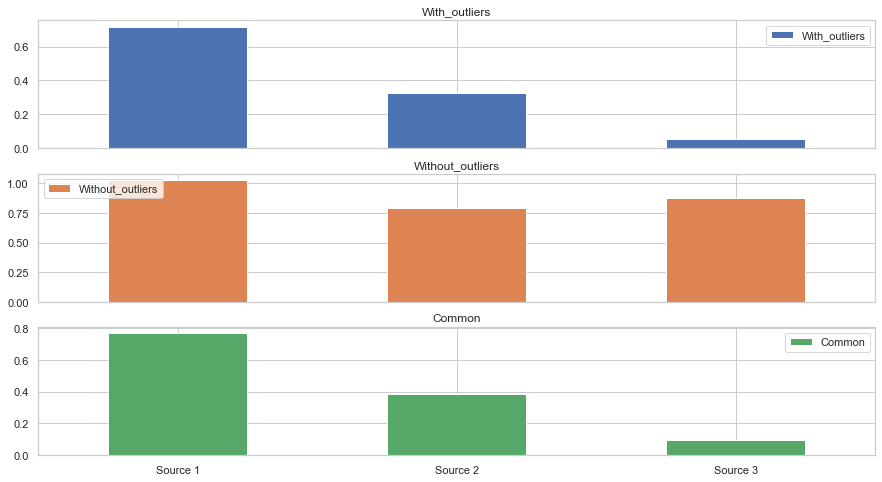

In [616]:
plot_three_types_of_data(dif_std_U, dif_std_U_no_outliers, dif_std_U_common)

#### Ploting all 3 bar plots of Std %U distances from the learning set. We can see similar results between "with outliers", and "Common"- where source3 has higher distance than source2, while in "Without outliers" source 2 has a higher distance than source 3
###    

### Difference between 'V' * % U' Std
#### Calculate for each external source the absulote value of the difference in  'V' * % U' Std between the learning set and the source

In [617]:
data0_VmulU_std = (data0['V'] * data0['% U']).std()
data1_VmulU_std = (data1['V'] * data1['% U']).std()
data2_VmulU_std = (data2['V'] * data2['% U']).std()
data3_VmulU_std = (data3['V'] * data3['% U']).std()

In [618]:
dif_std_VmulU1 = abs(data0_VmulU_std / data1_VmulU_std)
dif_std_VmulU2 = abs(data0_VmulU_std / data2_VmulU_std)
dif_std_VmulU3 = abs(data0_VmulU_std / data3_VmulU_std)

dif_std_VmulU = [dif_std_VmulU1, dif_std_VmulU2, dif_std_VmulU3]
display(dif_std_VmulU)

[0.45326955453426454, 0.10455701342070152, 0.002269972378931632]

#### With outliers - source 1 is the closests, then source 2 and then source 3. Source 1 and source 2 has close distances to the learning set.

In [619]:
dif_std_VmulU1_no_outliers = abs(data0_VmulU_std / (data_01_no_outliers['V'] * data_01_no_outliers['% U']).std())
dif_std_VmulU2_no_outliers = abs(data0_VmulU_std / (data_02_no_outliers['V'] * data_02_no_outliers['% U']).std())
dif_std_VmulU3_no_outliers = abs(data0_VmulU_std / (data_03_no_outliers['V'] * data_03_no_outliers['% U']).std())

dif_std_VmulU_no_outliers = [dif_std_VmulU1_no_outliers, dif_std_VmulU2_no_outliers, dif_std_VmulU3_no_outliers]
display(dif_std_VmulU_no_outliers)

[1.1059981748743548, 0.9572072243406874, 0.975153378900131]

#### Without outliers - source 3 is the closests, then source 2 and then source 1.

In [620]:
dif_std_VmulU1_common = abs((data0_for1['V'] * data0_for1['% U']).std() / data1_VmulU_std)
dif_std_VmulU2_common = abs((data0_for2['V'] * data0_for2['% U']).std() / data2_VmulU_std)
dif_std_VmulU3_common = abs((data0_for3['V'] * data0_for3['% U']).std() / data3_VmulU_std)

dif_std_VmulU_common = [dif_std_VmulU1_common, dif_std_VmulU2_common, dif_std_VmulU3_common]
display(dif_std_VmulU_common)

[0.4840806029597307, 0.12531459124513633, 0.0038228782497570332]

#### Data0 with only common sites - source 1 is the closests, then source 2 and then source 3.  Source 1 and source 2 has close distances to the learning set.

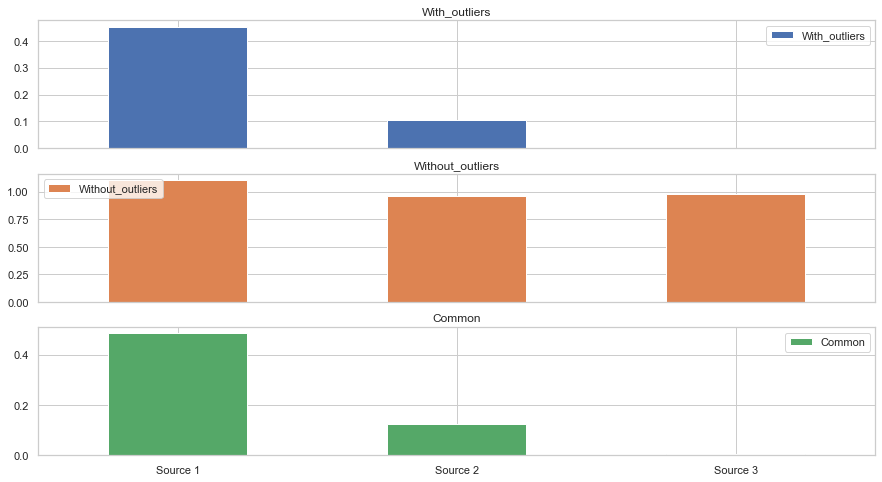

In [621]:
plot_three_types_of_data(dif_std_VmulU, dif_std_VmulU_no_outliers, dif_std_VmulU_common)

#### Ploting all 3 bar plots of Std %U * V distances from the learning set. We can see similar results between "with outliers", and "Common"- where source3 has higher distance than source2 and source1, while in "Without outliers" we see the oposite picture- source1 has higher distance than source2 and source3.
###    

In [1241]:
data0_small = data0.loc[data0['V'] <= 7000]
data1_small = data1.loc[data1['V'] <= 7000]
data2_small = data2.loc[data2['V'] <= 7000]
data3_small = data3.loc[data3['V'] <= 7000]

data0_mid = data0[(data0['V'] < 100000 ) & (data0['V'] >= 7000)]
data1_mid = data1[(data1['V'] < 100000 ) & (data1['V'] >= 7000)]
data2_mid = data2[(data2['V'] < 100000 ) & (data2['V'] >= 7000)]
data3_mid = data3[(data3['V'] < 100000 ) & (data3['V'] >= 7000)]

data0_big = data0.loc[data0['V'] >= 100000]
data1_big = data1.loc[data1['V'] >= 100000]
data2_big = data2.loc[data2['V'] >= 100000]
data3_big = data3.loc[data3['V'] >= 100000]

In [1242]:
data0_V_mean_small = data0_small['V'].mean()
data1_V_mean_small = data1_small['V'].mean()
data2_V_mean_small = data2_small['V'].mean()
data3_V_mean_small = data3_small['V'].mean()

data0_V_mean_mid = data0_mid['V'].mean()
data1_V_mean_mid = data1_mid['V'].mean()
data2_V_mean_mid = data2_mid['V'].mean()
data3_V_mean_mid = data3_mid['V'].mean()

data0_V_mean_big = data0_big['V'].mean()
data1_V_mean_big = data1_big['V'].mean()
data2_V_mean_big = data2_big['V'].mean()
data3_V_mean_big = data3_big['V'].mean()

In [1251]:
dif_avg_V1_small = data0_V_mean_small / data1_V_mean_small
dif_avg_V2_small = data0_V_mean_small / data2_V_mean_small
dif_avg_V3_small = data0_V_mean_small / data3_V_mean_small

dif_avg_V1_mid = data0_V_mean_mid / data1_V_mean_mid
dif_avg_V2_mid = data0_V_mean_mid / data2_V_mean_mid
dif_avg_V3_mid = data0_V_mean_mid / data3_V_mean_mid

dif_avg_V1_big = data0_V_mean_big / data1_V_mean_big
dif_avg_V2_big = data0_V_mean_big / data2_V_mean_big
dif_avg_V3_big = data0_V_mean_big / data3_V_mean_big

dif_avg_V_small = [dif_avg_V1_small, dif_avg_V2_small, dif_avg_V3_small]
display(dif_avg_V_small)

dif_avg_V_mid = [dif_avg_V1_mid, dif_avg_V2_mid, dif_avg_V3_mid]
display(dif_avg_V_mid)

dif_avg_V_big = [dif_avg_V1_big, dif_avg_V2_big, dif_avg_V3_big]
display(dif_avg_V_big)

[1.3273245646219884, 1.067283445257931, 1.1651013689327705]

[0.9057032944485226, 0.7486147907294469, 0.8453762094077281]

[0.8865562582566541, 0.6102888136039777, 0.30619439586203445]

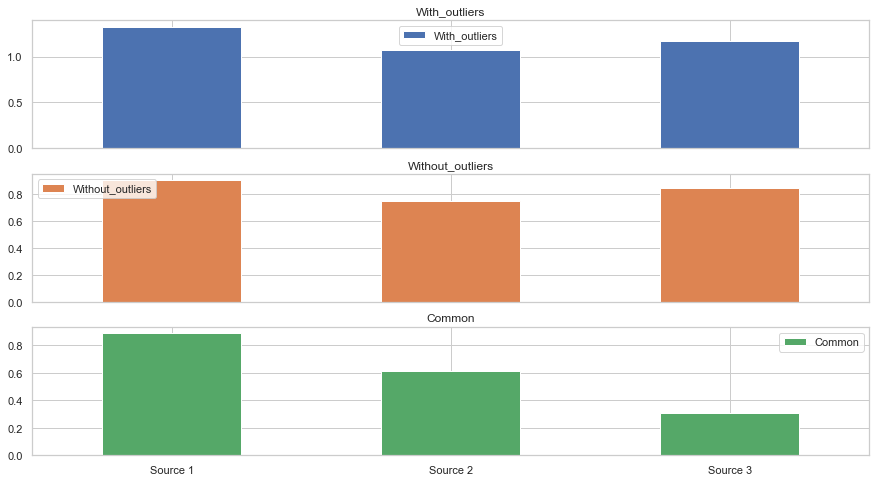

In [1252]:
plot_three_types_of_data(dif_avg_V_small, dif_avg_V_mid, dif_avg_V_big)

In [1224]:
data0_V_median_small = data0_small['V'].median()
data1_V_median_small = data1_small['V'].median()
data2_V_median_small = data2_small['V'].median()
data3_V_median_small = data3_small['V'].median()

data0_V_median_mid = data0_mid['V'].median()
data1_V_median_mid = data1_mid['V'].median()
data2_V_median_mid = data2_mid['V'].median()
data3_V_median_mid = data3_mid['V'].median()

data0_V_median_big = data0_big['V'].median()
data1_V_median_big = data1_big['V'].median()
data2_V_median_big = data2_big['V'].median()
data3_V_median_big = data3_big['V'].median()

In [ ]:
dif_avg_v1_small = 

In [1245]:
display(len(data1_small)/len(data1))
display(len(data1_mid)/len(data1))
display(len(data1_big)/len(data1))

0.0871559633027523

0.548459186073865

0.3643848506233827

In [ ]:
data0_V_mean = data0['V'].mean()
data1_V_mean = data1['V'].mean()
data2_V_mean = data2['V'].mean()
data3_V_mean = data3['V'].mean()

dif_avg_V1_big = abs(data0_V_mean / data1_V_mean)
dif_avg_V2 = abs(data0_V_mean / data2_V_mean)
dif_avg_V3 = abs(data0_V_mean / data3_V_mean)

dif_avg_V = [dif_avg_V1, dif_avg_V2, dif_avg_V3]
display(dif_avg_V)

## Creating source quality metric

#### We will use all metrics in order to calculate each source quality. Therefore we aggregate for each external source all its metrics

In [965]:
source1_quality_vec = [dif_avg_V1, dif_avg_V1_no_outliers, dif_avg_V_1_common, dif_avg_U1, dif_avg_U1_no_outliers, dif_avg_U_1_common, dif_avg_VmulU1, dif_avg_VmulU1_no_outliers, dif_avg_VmulU1_common, dif_median_V1, dif_median_V1_no_outliers, dif_median_V_1_common, dif_median_U1, dif_median_U1_no_outliers, dif_median_U_1_common, dif_median_VmulU1, dif_median_VmulU1_no_outliers, dif_median_VmulU1_common, dif_std_V1, dif_std_V1_no_outliers, dif_std_V_1_common, dif_std_U1, dif_std_U1_no_outliers, dif_std_U_1_common, dif_std_VmulU1, dif_std_VmulU1_no_outliers, dif_std_VmulU1_common]
source2_quality_vec = [dif_avg_V2, dif_avg_V2_no_outliers, dif_avg_V_2_common, dif_avg_U2, dif_avg_U2_no_outliers, dif_avg_U_2_common, dif_avg_VmulU2, dif_avg_VmulU2_no_outliers, dif_avg_VmulU2_common, dif_median_V2, dif_median_V2_no_outliers, dif_median_V_2_common, dif_median_U2, dif_median_U2_no_outliers, dif_median_U_2_common, dif_median_VmulU2, dif_median_VmulU2_no_outliers, dif_median_VmulU2_common, dif_std_V2, dif_std_V2_no_outliers, dif_std_V_2_common, dif_std_U2, dif_std_U2_no_outliers, dif_std_U_2_common, dif_std_VmulU2, dif_std_VmulU2_no_outliers, dif_std_VmulU2_common]
source3_quality_vec = [dif_avg_V3, dif_avg_V3_no_outliers, dif_avg_V_3_common, dif_avg_U3, dif_avg_U3_no_outliers, dif_avg_U_3_common, dif_avg_VmulU3, dif_avg_VmulU3_no_outliers, dif_avg_VmulU3_common, dif_median_V3, dif_median_V3_no_outliers, dif_median_V_3_common, dif_median_U3, dif_median_U3_no_outliers, dif_median_U_3_common, dif_median_VmulU3, dif_median_VmulU3_no_outliers, dif_median_VmulU3_common, dif_std_V3, dif_std_V3_no_outliers, dif_std_V_3_common, dif_std_U3, dif_std_U3_no_outliers, dif_std_U_3_common, dif_std_VmulU3, dif_std_VmulU3_no_outliers, dif_std_VmulU3_common]

In [966]:
source1_v_quality_vec = [dif_avg_V1, dif_avg_V1_no_outliers, dif_avg_V_1_common, dif_median_V1, dif_median_V1_no_outliers, dif_median_V_1_common, dif_std_V1, dif_std_V1_no_outliers, dif_std_V_1_common]
source2_v_quality_vec = [dif_avg_V2, dif_avg_V2_no_outliers, dif_avg_V_2_common, dif_median_V2, dif_median_V2_no_outliers, dif_median_V_2_common, dif_std_V2, dif_std_V2_no_outliers, dif_std_V_2_common]
source3_v_quality_vec = [dif_avg_V3, dif_avg_V3_no_outliers, dif_avg_V_3_common, dif_median_V3, dif_median_V3_no_outliers, dif_median_V_3_common, dif_std_V3, dif_std_V3_no_outliers, dif_std_V_3_common]

In [967]:
source1_u_quality_vec = [dif_avg_U1, dif_avg_U1_no_outliers, dif_avg_U_1_common, dif_median_U1, dif_median_U1_no_outliers, dif_median_U_1_common, dif_std_U1, dif_std_U1_no_outliers, dif_std_U_1_common]
source2_u_quality_vec = [dif_avg_U2, dif_avg_U2_no_outliers, dif_avg_U_2_common, dif_median_U2, dif_median_U2_no_outliers, dif_median_U_2_common, dif_std_U2, dif_std_U2_no_outliers, dif_std_U_2_common]
source3_u_quality_vec = [dif_avg_U3, dif_avg_U3_no_outliers, dif_avg_U_3_common, dif_median_U3, dif_median_U3_no_outliers, dif_median_U_3_common, dif_std_U3, dif_std_U3_no_outliers, dif_std_U_3_common]

In [970]:
source1_v_quality_num = np.mean(source1_v_quality_vec)
source2_v_quality_num = np.mean(source2_v_quality_vec)
source3_v_quality_num = np.mean(source3_v_quality_vec)

display(source1_v_quality_num)
display(source2_v_quality_num)
display(source3_v_quality_num)

0.8778218764821399

0.5023359498094516

0.5262751111631143

In [971]:
source1_u_quality_num = np.mean(source1_u_quality_vec)
source2_u_quality_num = np.mean(source2_u_quality_vec)
source3_u_quality_num = np.mean(source3_u_quality_vec)

display(source1_u_quality_num)
display(source2_u_quality_num)
display(source3_u_quality_num)

0.9103102973252604

0.4853766474090574

0.49308171890373775

#### Create a dataframe with column for each source, and the values of all metrics

In [627]:
sources_qualities = pd.DataFrame({'Source 1': source1_quality_vec,
                   'Source 2': source2_quality_vec,
                    'Source 3': source3_quality_vec})
sources_qualities

,Source 1,Source 2,Source 3
0,0.8061293280,0.3546216644,0.1784833596
1,0.9507888222,0.6536596039,0.7659332091
2,0.9088129132,0.4947045808,0.4578634637
3,0.8570742569,0.3512248788,0.1780794870
4,0.9792068346,0.6414934694,0.7288342306
5,0.9668007546,0.4898169630,0.4575021919
6,0.5191120488,0.1081366220,0.0032264843
7,1.0499936648,0.6615605787,0.8063435172
8,0.5903427112,0.1547805340,0.0090939295
9,0.7915335043,0.2880926835,0.2646817213


#### Calculate the quantitative recommendation for the quality of each of the External Sources

In [628]:
source1_quality = np.mean(source1_quality_vec)
source2_quality = np.mean(source2_quality_vec)
source3_quality = np.mean(source3_quality_vec)

display(source1_quality)
display(source2_quality)
display(source3_quality)

0.8477858855200787

0.4335577199083133

0.4776323047401977

## Estimate Visits by using the external sources

#### Create a new dataframe - each site has the actual V (V0), and the V1-3 for each external source

In [1692]:
data1_relevant_columns = pd.DataFrame(data1, columns = ['site', 'V']) 
data2_relevant_columns = pd.DataFrame(data2, columns = ['site', 'V']) 
data3_relevant_columns = pd.DataFrame(data3, columns = ['site', 'V']) 

data_0123 = pd.merge(pd.merge(pd.merge(data0, data1_relevant_columns, how='outer', left_on='site', right_on='site'),
                    data2_relevant_columns, how='outer', left_on='site', right_on='site'),
                    data3_relevant_columns, how='outer', left_on='site', right_on='site')

del data_0123['source']
data_0123.columns = ['site','% U','V0','V1','V2','V3']

data_before_predict = data_0123.copy()

#### As expected, there are nan for some of the V in the external sources. I verified that indeed the count of nans for each external source is equal to: the #sites in the learning set - #sites in the external source, since each external source has differnet number of sites (but all of them appear in the learning set), and for each external source and the learning set the sites are unique.

In [1693]:
data_0123.isnull().sum()

site       0
% U        0
V0         0
V1      1197
V2      2950
V3      6285
dtype: int64

#### Remove observations which doesn't have V1-3 and %U1-3 values, since we do not have external information about them, we cannot predict them properly.

In [1694]:
data_0123.dropna(axis=0, how= 'all', subset=['V1','V2','V3'], inplace = True)
data_0123.head()

,site,% U,V0,V1,V2,V3
0,06880danwoog.com*,0.0000033431,36280.0000000000,74508.9416692836,77524.4506031888,nan
1,0800-horoscope.com*,0.0000107503,120690.0000000000,88514.4705800152,172408.7952948560,74442.3414620303
2,10000boatnames.com*,0.0000005871,6858.0000000000,7476.7074182638,nan,nan
3,100bestvacations.com*,0.0000015168,12891.0000000000,10568.1874182638,nan,nan
4,100stuartstreet.com*,0.0000011282,9758.0000000000,18726.7353686582,nan,nan


### Baseline- predict V (V0) by calculating the mean of: V1, V2, V3 without using the quality metrics.

In [1695]:
data_0123['Predicted V'] = data_0123[['V1', 'V2', 'V3']].mean(axis=1)
data_0123.head()

,site,% U,V0,V1,V2,V3,Predicted V
0,06880danwoog.com*,0.0000033431,36280.0000000000,74508.9416692836,77524.4506031888,nan,76016.6961362362
1,0800-horoscope.com*,0.0000107503,120690.0000000000,88514.4705800152,172408.7952948560,74442.3414620303,111788.5357789672
2,10000boatnames.com*,0.0000005871,6858.0000000000,7476.7074182638,nan,nan,7476.7074182638
3,100bestvacations.com*,0.0000015168,12891.0000000000,10568.1874182638,nan,nan,10568.1874182638
4,100stuartstreet.com*,0.0000011282,9758.0000000000,18726.7353686582,nan,nan,18726.7353686582


## Evaluation

#### I chose to use MAPE- Mean Absolute Percentage Error, since V values are between 1020 and 4,872,713,002. An error of 1000 on value of V of 1020 should be much higher than an error of 1000 on value of V of 4,000,000,000.
#### Baseline- MAPE= 50% error.

In [1696]:
display(np.mean(abs(data_0123['V0']-data_0123['Predicted V'])/data_0123['V0']))

0.5024849444272855

###  Option 2: Multipling each V1-3 and the source general quality

In [1697]:
data_0123['V1_adjusted'] = data_0123['V1'] * source1_quality
data_0123['V2_adjusted'] = data_0123['V2'] * source2_quality
data_0123['V3_adjusted'] = data_0123['V3'] * source3_quality

data_0123.head()

,site,% U,V0,V1,V2,V3,Predicted V,V1_adjusted,V2_adjusted,V3_adjusted
0,06880danwoog.com*,0.0000033431,36280.0000000000,74508.9416692836,77524.4506031888,nan,76016.6961362362,63167.6290922575,33611.3240406632,nan
1,0800-horoscope.com*,0.0000107503,120690.0000000000,88514.4705800152,172408.7952948560,74442.3414620303,111788.5357789672,75041.3188220191,74749.1641801769,35556.0671227663
2,10000boatnames.com*,0.0000005871,6858.0000000000,7476.7074182638,nan,nan,7476.7074182638,6338.6470193673,nan,nan
3,100bestvacations.com*,0.0000015168,12891.0000000000,10568.1874182638,nan,nan,10568.1874182638,8959.5601287349,nan,nan
4,100stuartstreet.com*,0.0000011282,9758.0000000000,18726.7353686582,nan,nan,18726.7353686582,15876.2619274181,nan,nan


#### Try predict V (V0) by calculating the mean for the adjusted values of: V1, V2, V3 (adjusted by each external source quality number)

In [1698]:
data_0123['Predicted V adjusted'] = data_0123[['V1_adjusted', 'V2_adjusted', 'V3_adjusted']].mean(axis=1)
data_0123.sort_values(by=['Predicted V'])

,site,% U,V0,V1,V2,V3,Predicted V,V1_adjusted,V2_adjusted,V3_adjusted,Predicted V adjusted
789,barbarianbabes.com*,0.0000004068,5070.0000000000,1020.1066907178,nan,nan,1020.1066907178,864.8320541151,nan,nan,864.8320541151
2572,eaglespringstx.com*,0.0000005321,5216.0000000000,1085.2700037580,nan,nan,1085.2700037580,920.0765911644,nan,nan,920.0765911644
7089,ripvanwinklecampgrounds.com*,0.0000004587,5287.0000000000,1257.8569530252,nan,nan,1257.8569530252,1066.3933707781,nan,nan,1066.3933707781
6806,pups-seeking-homes.com*,0.0000006134,5020.0000000000,1269.0369394964,nan,nan,1269.0369394964,1075.8716055086,nan,nan,1075.8716055086
5848,myozarksonline.com*,0.0000004837,5417.0000000000,1274.4722435175,nan,nan,1274.4722435175,1080.4795795412,nan,nan,1080.4795795412
...,...,...,...,...,...,...,...,...,...,...,...
8738,tumblr.com*,0.0162663169,261974470.0000000000,247046652.2457720339,607636184.3370860815,230080174.4942350090,361587670.3590310216,209442664.8389527798,263445358.6149746180,109893724.0187083185,194260582.4908785820
5115,linkedin.com*,0.0208053980,232618922.0000000000,371388369.4144049883,677467750.4507969618,112019559.5163270086,386958559.7938429713,314857817.6358494759,293721373.1968617439,53504160.3877650127,220694450.4068254232
4284,huffingtonpost.com*,0.0208585935,245887198.0000000000,345940543.0474460125,693700639.8028669357,133582035.0038580149,391074405.9513903260,293283509.6247759461,300759267.6918691397,63803095.2507784665,219281957.5224745274
8070,techbrowsing.com*,0.0045497446,65554999.0000000000,44135310.9083017930,135627963.2094680071,2730222516.4482398033,969995263.5220031738,37417293.6410986260,58802550.4849055558,1304042472.9847550392,466754105.7035863996


#### Evalutation of option 2 by using MAPE-  see how accurate we are by using the adjusted V1-3 which were created by using the general quality numbers for each external source. 11% error.

In [1699]:
np.mean(abs(data_0123['V0']-data_0123['Predicted V adjusted'])/data_0123['V0'])

0.31549816324118757

###  Multipling each V1-3 in the source quality based on V metrics only

In [1702]:
data_0123['V1_adjusted_byV'] = data_0123['V1'] * source1_v_quality_num
data_0123['V2_adjusted_byV'] = data_0123['V2'] * source2_v_quality_num
data_0123['V3_adjusted_byV'] = data_0123['V3'] * source3_v_quality_num

data_0123.head()

,site,% U,V0,V1,V2,V3,Predicted V,V1_adjusted,V2_adjusted,V3_adjusted,Predicted V adjusted,V1_adjusted_byV,V2_adjusted_byV,V3_adjusted_byV
0,06880danwoog.com*,0.0000033431,36280.0000000000,74508.9416692836,77524.4506031888,nan,76016.6961362362,63167.6290922575,33611.3240406632,nan,48389.4765664603,65405.5789908288,38943.3185272088,nan
1,0800-horoscope.com*,0.0000107503,120690.0000000000,88514.4705800152,172408.7952948560,74442.3414620303,111788.5357789672,75041.3188220191,74749.1641801769,35556.0671227663,61782.1833749874,77699.9386603721,86607.1359399448,39177.1515281725
2,10000boatnames.com*,0.0000005871,6858.0000000000,7476.7074182638,nan,nan,7476.7074182638,6338.6470193673,nan,nan,6338.6470193673,6563.2173358083,nan,nan
3,100bestvacations.com*,0.0000015168,12891.0000000000,10568.1874182638,nan,nan,10568.1874182638,8959.5601287349,nan,nan,8959.5601287349,9276.9861105153,nan,nan
4,100stuartstreet.com*,0.0000011282,9758.0000000000,18726.7353686582,nan,nan,18726.7353686582,15876.2619274181,nan,nan,15876.2619274181,16438.7379817000,nan,nan


#### Try predict V (V0) by calculating the mean for the adjusted values by V of: V1, V2, V3 (adjusted by each external source quality V number)

In [1703]:
data_0123['Predicted V adjusted_byV'] = data_0123[['V1_adjusted_byV', 'V2_adjusted_byV', 'V3_adjusted_byV']].mean(axis=1)
data_0123.sort_values(by=['Predicted V adjusted_byV'])

,site,% U,V0,V1,V2,V3,Predicted V,V1_adjusted,V2_adjusted,V3_adjusted,Predicted V adjusted,V1_adjusted_byV,V2_adjusted_byV,V3_adjusted_byV,Predicted V adjusted_byV
789,barbarianbabes.com*,0.0000004068,5070.0000000000,1020.1066907178,nan,nan,1020.1066907178,864.8320541151,nan,nan,864.8320541151,895.4719694579,nan,nan,895.4719694579
2572,eaglespringstx.com*,0.0000005321,5216.0000000000,1085.2700037580,nan,nan,1085.2700037580,920.0765911644,nan,nan,920.0765911644,952.6737511886,nan,nan,952.6737511886
6728,primo168.tw*,0.0000003072,5955.0000000000,nan,nan,1854.1123044373,1854.1123044373,nan,nan,885.5839332155,885.5839332155,nan,nan,975.7731591266,975.7731591266
7089,ripvanwinklecampgrounds.com*,0.0000004587,5287.0000000000,1257.8569530252,nan,nan,1257.8569530252,1066.3933707781,nan,nan,1066.3933707781,1104.1743508507,nan,nan,1104.1743508507
6806,pups-seeking-homes.com*,0.0000006134,5020.0000000000,1269.0369394964,nan,nan,1269.0369394964,1075.8716055086,nan,nan,1075.8716055086,1113.9883875539,nan,nan,1113.9883875539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8738,tumblr.com*,0.0162663169,261974470.0000000000,247046652.2457720339,607636184.3370860815,230080174.4942350090,361587670.3590310216,209442664.8389527798,263445358.6149746180,109893724.0187083185,194260582.4908785820,216862955.8530142903,305237499.7975611687,121085469.4083822668,214395308.3529858887
4284,huffingtonpost.com*,0.0208585935,245887198.0000000000,345940543.0474460125,693700639.8028669357,133582035.0038580149,391074405.9513903260,293283509.6247759461,300759267.6918691397,63803095.2507784665,219281957.5224745274,303674176.6491595507,348470769.7787974477,70300900.3210504055,240815282.2496691644
5115,linkedin.com*,0.0208053980,232618922.0000000000,371388369.4144049883,677467750.4507969618,112019559.5163270086,386958559.7938429713,314857817.6358494759,293721373.1968617439,53504160.3877650127,220694450.4068254232,326012835.3429951668,340316405.8879736662,58953106.1368981004,241760782.4559556544
8070,techbrowsing.com*,0.0045497446,65554999.0000000000,44135310.9083017930,135627963.2094680071,2730222516.4482398033,969995263.5220031738,37417293.6410986260,58802550.4849055558,1304042472.9847550392,466754105.7035863996,38742941.4406481385,68130801.7195494771,1436848158.3438351154,514573967.1680108905


#### Calculate the percentage of - predicted V adjusted by V / V0, and see how accurate we are by using the adjusted V1-3_byV while using the V quality numbers for each external source. 46% 

In [1704]:
np.mean(abs(data_0123['V0']-data_0123['Predicted V adjusted_byV'])/data_0123['V0'])

0.3039984276463614

In [1738]:
errors = abs(data_0123['V0']-data_0123['Predicted V adjusted_byV'])
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))
display(np.mean(errors/data_0123['V0']))

Mean Absolute Error: 311094.4


0.3039984276463614

### Try using ML algorighms in order to predict V0

In [1821]:
data1_relevant_columns_vu = pd.DataFrame(data1, columns = ['site', 'V', '% U']) 
data2_relevant_columns_vu = pd.DataFrame(data2, columns = ['site', 'V', '% U']) 
data3_relevant_columns_vu = pd.DataFrame(data3, columns = ['site', 'V', '% U']) 

data_before_predict_vu = pd.merge(pd.merge(pd.merge(data0, data1_relevant_columns_vu, how='outer', left_on='site', right_on='site'),
                    data2_relevant_columns_vu, how='outer', left_on='site', right_on='site'),
                    data3_relevant_columns_vu, how='outer', left_on='site', right_on='site')

del data_before_predict_vu['source']
data_before_predict_vu.columns = ['site','% U','V0','V1', '% U1','V2', '% U2','V3', '% U3']
del data_before_predict_vu['% U']
del data_before_predict_vu['site']
data_before_predict_vu.head()

,V0,V1,% U1,V2,% U2,V3,% U3
0,36280.0000000000,74508.9416692836,0.0000050648,77524.4506031888,0.0000086720,nan,nan
1,120690.0000000000,88514.4705800152,0.0000079767,172408.7952948560,0.0000192860,74442.3414620303,0.0000087937
2,6858.0000000000,7476.7074182638,0.0000007662,nan,nan,nan,nan
3,12891.0000000000,10568.1874182638,0.0000010830,nan,nan,nan,nan
4,9758.0000000000,18726.7353686582,0.0000019191,nan,nan,nan,nan


In [1822]:
data1_relevant_columns_v = pd.DataFrame(data1, columns = ['site', 'V']) 
data2_relevant_columns_v = pd.DataFrame(data2, columns = ['site', 'V']) 
data3_relevant_columns_v = pd.DataFrame(data3, columns = ['site', 'V']) 

data_before_predict_v = pd.merge(pd.merge(pd.merge(data0, data1_relevant_columns_v, how='outer', left_on='site', right_on='site'),
                    data2_relevant_columns_v, how='outer', left_on='site', right_on='site'),
                    data3_relevant_columns_v, how='outer', left_on='site', right_on='site')

del data_before_predict_v['source']
data_before_predict_v.columns = ['site','% U','V0','V1','V2','V3']
del data_before_predict_v['% U']
data_before_predict_v.head()

,site,V0,V1,V2,V3
0,06880danwoog.com*,36280.0000000000,74508.9416692836,77524.4506031888,nan
1,0800-horoscope.com*,120690.0000000000,88514.4705800152,172408.7952948560,74442.3414620303
2,10000boatnames.com*,6858.0000000000,7476.7074182638,nan,nan
3,100bestvacations.com*,12891.0000000000,10568.1874182638,nan,nan
4,100stuartstreet.com*,9758.0000000000,18726.7353686582,nan,nan


In [1823]:
data1_relevant_columns_u = pd.DataFrame(data1, columns = ['site', '% U']) 
data2_relevant_columns_u = pd.DataFrame(data2, columns = ['site', '% U']) 
data3_relevant_columns_u = pd.DataFrame(data3, columns = ['site', '% U']) 

data_before_predict_u = pd.merge(pd.merge(pd.merge(data0, data1_relevant_columns_u, how='outer', left_on='site', right_on='site'),
                    data2_relevant_columns_u, how='outer', left_on='site', right_on='site'),
                    data3_relevant_columns_u, how='outer', left_on='site', right_on='site')

del data_before_predict_u['source']
data_before_predict_u.columns = ['site','% U','V0','% U1','% U2','% U3']
del data_before_predict_u['% U']
data_before_predict_u.head()

,site,V0,% U1,% U2,% U3
0,06880danwoog.com*,36280.0000000000,0.0000050648,0.0000086720,nan
1,0800-horoscope.com*,120690.0000000000,0.0000079767,0.0000192860,0.0000087937
2,10000boatnames.com*,6858.0000000000,0.0000007662,nan,nan
3,100bestvacations.com*,12891.0000000000,0.0000010830,nan,nan
4,100stuartstreet.com*,9758.0000000000,0.0000019191,nan,nan


In [1824]:
only_v = data_before_predict_v[['V1', 'V2', 'V3']]
only_u = data_before_predict_u[['% U1', '% U2', '% U3']]

#### Fill nans by the mean of the other V columns values

In [1825]:
only_v['V3'] = only_v.apply(
    lambda row: row[~np.isnan(row)].mean() if np.isnan(row['V3']) else row['V3'],
    axis=1
)

only_v['V2'] = only_v.apply(
    lambda row: row[~np.isnan(row)].mean() if np.isnan(row['V2']) else row['V2'],
    axis=1
)
only_v['V1'] = only_v.apply(
    lambda row: row[~np.isnan(row)].mean() if np.isnan(row['V1']) else row['V1'],
    axis=1
)

C:\Users\or.hirshman\Downloads\WPy64-3771\python-3.7.7.amd64\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\or.hirshman\Downloads\WPy64-3771\python-3.7.7.amd64\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\or.hirshman\Downloads\WPy64-3771\python-3.7.7.amd64\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be s

#### Fill nans by the mean of the other %U columns values

In [1826]:
only_u['% U3'] = only_u.apply(
    lambda row: row[~np.isnan(row)].mean() if np.isnan(row['% U3']) else row['% U3'],
    axis=1
)

only_u['% U2'] = only_u.apply(
    lambda row: row[~np.isnan(row)].mean() if np.isnan(row['% U2']) else row['% U2'],
    axis=1
)
only_u['% U1'] = only_u.apply(
    lambda row: row[~np.isnan(row)].mean() if np.isnan(row['% U1']) else row['% U1'],
    axis=1
)

C:\Users\or.hirshman\Downloads\WPy64-3771\python-3.7.7.amd64\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\or.hirshman\Downloads\WPy64-3771\python-3.7.7.amd64\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\or.hirshman\Downloads\WPy64-3771\python-3.7.7.amd64\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be s

In [1827]:
data_before_predict_vu['% U1'] = only_u['% U1']
data_before_predict_vu['% U2'] = only_u['% U2']
data_before_predict_vu['% U3'] = only_u['% U3']

data_before_predict_vu['V1'] = only_v['V1']
data_before_predict_vu['V2'] = only_v['V2']
data_before_predict_vu['V3'] = only_v['V3']

data_before_predict = data_before_predict_vu.copy()
data_before_predict.head()

,V0,V1,% U1,V2,% U2,V3,% U3
0,36280.0000000000,74508.9416692836,0.0000050648,77524.4506031888,0.0000086720,76016.6961362362,0.0000068684
1,120690.0000000000,88514.4705800152,0.0000079767,172408.7952948560,0.0000192860,74442.3414620303,0.0000087937
2,6858.0000000000,7476.7074182638,0.0000007662,7476.7074182638,0.0000007662,7476.7074182638,0.0000007662
3,12891.0000000000,10568.1874182638,0.0000010830,10568.1874182638,0.0000010830,10568.1874182638,0.0000010830
4,9758.0000000000,18726.7353686582,0.0000019191,18726.7353686582,0.0000019191,18726.7353686582,0.0000019191


#### Remove rows when all external sources data is nan, cannot predict properly by those observations

In [1828]:
data_before_predict.dropna(axis=0, how= 'all', subset=['V1','V2','V3'], inplace = True)

#### Define y and X

In [1829]:
X = data_before_predict.loc[:, data_before_predict.columns != 'V0']
y = data_before_predict['V0'].values

In [1830]:
X.head()

,V1,% U1,V2,% U2,V3,% U3
0,74508.9416692836,0.0000050648,77524.4506031888,0.0000086720,76016.6961362362,0.0000068684
1,88514.4705800152,0.0000079767,172408.7952948560,0.0000192860,74442.3414620303,0.0000087937
2,7476.7074182638,0.0000007662,7476.7074182638,0.0000007662,7476.7074182638,0.0000007662
3,10568.1874182638,0.0000010830,10568.1874182638,0.0000010830,10568.1874182638,0.0000010830
4,18726.7353686582,0.0000019191,18726.7353686582,0.0000019191,18726.7353686582,0.0000019191


#### Split to training and validation 

In [1831]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

#### Verify there are no nans

In [1832]:
X.isnull().sum()

V1      0
% U1    0
V2      0
% U2    0
V3      0
% U3    0
dtype: int64

In [1833]:
X_train.head()

,V1,% U1,V2,% U2,V3,% U3
6031,679372.5170872139,0.0000665089,319573.5537957750,0.0000334838,499473.0354414944,0.0000499963
8340,14619.0833040210,0.0000014982,40833.4664459912,0.0000045677,27726.2748750061,0.0000030329
4163,120147.9129504410,0.0000113792,351573.6475346950,0.0000393277,235860.7802425680,0.0000253535
7077,39420.9026119385,0.0000038269,120072.6672189250,0.0000122888,79746.7849154318,0.0000080579
6823,120196.7689034390,0.0000118311,346770.0777902520,0.0000387904,233483.4233468455,0.0000253107


### Baseline

#### Create a dummy regressor

In [1849]:
dummy_mean = DummyRegressor(strategy='mean')

#### "Train" dummy regressor

In [1850]:
dummy_mean.fit(X_train, y_train)

DummyRegressor()

#### "predict" by dummy regressor

In [1852]:
predictions = dummy_mean.predict(X_test)

#### MAPE-

In [1853]:
errors = abs(predictions - y_test)
display(np.mean(errors/y_test))

25.298404127199394

#### An extremly big error of MAPE by using the dummy regressor

### Random forest:

#### Instantiate model with 1000 decision trees

In [ ]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

#### Train the model on training data

In [ ]:
rf.fit(X_train, y_train)

#### Use the random forest's predict method on the test data

In [1838]:
predictions = rf.predict(X_test)

#### MAPE-

In [1843]:
errors = abs(predictions - y_test)
display(np.mean(errors/y_test))

0.3425426154633453

### XGBoost:

#### Instantiate model with 1000 decision trees

In [1840]:
xgb_r = xgb.XGBRegressor(n_estimators=1000) 

#### Train the model on training data

In [1841]:
xgb_r.fit(X_train, y_train) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### Use the random forest's predict method on the test data

In [1842]:
xgb_pred = xgb_r.predict(X_test) 

#### MAPE-

In [1844]:
errors = abs(xgb_pred - y_test)
display(np.mean(errors/y_test))

0.3570158218859736

### KNN

#### Instantiate KNN model with 10 neighbors

In [ ]:
knn = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=10))

#### Train the model on training data

In [ ]:
knn.fit(X_train, y_train)

#### Use the random forest's predict method on the test data

In [ ]:
knn_pred = knn.predict(X_test) 

#### MAPE-

In [1836]:
errors = abs(knn_pred - y_test)
display(np.mean(errors/y_test))

Mean Absolute Error: 265231.7


0.349453164860658

#### (I tried more ML algorithems with worse performances in this case- linear regression, regression decision tree, Adaboost, SVM, NN.)

### According to MAPE, we will choose the simplest algorithm which is the mean of the values of V for each external source, multiplied by the quality of it.

#### V prediction:

In [1854]:
data_0123['Predicted V adjusted_byV']

0       52174.4487590188
1       67828.0753761631
2        6563.2173358083
3        9276.9861105153
4       16438.7379817000
              ...       
9694    42540.9337712019
9695   676099.3333344600
9696    38999.6035402463
9697   815423.0321858077
9698    31171.4459616936
Name: Predicted V adjusted_byV, Length: 9004, dtype: float64